In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import commonutils
import models
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

from dataclasses import dataclass
import prettyprinter as pp

from sklearn.cross_decomposition import PLSRegression
import warnings
import sys

from sklearn import preprocessing

from copy import deepcopy

In [2]:
@dataclass
class ModelResults:
    # predicted values
    y_pred: list = None
    y_pred_mape: list = None
    y_pred_bestourmethod: list = None
    y_pred_bestinsidemethod: list = None
    # data related to full set
    fulldescriptors: list = None
    labels: list = None
    top_correlation: list = None
    # data realated to inside and our methods
    inside_methods_rmse: list = None
    bestinsidemethod_rmse: float = 0.0
    bestinsidemethod: str = None
    inside_methods_r2: list = None
    our_methods_rmse: dict = None
    bestourmethod_rmse: float = 0.0
    bestourmethod: str = None
    our_methods_r2: dict = None
    our_methods_name : list = None

def read_and_init (inrootdir, supersetnames, howmanydifs, methods, \
                   DEBUG=False):
    
    allvalues_perset = {}
    fullsetnames = []
    models_results = {}

    toberemoved = {}
    for super_setname in supersetnames:
        toberemoved[super_setname] = []
        allvalues_perset[super_setname] = []
        fullsetnames.append(super_setname)
        for i, setname in enumerate(supersetnames[super_setname]):
              print("Reading dataset: ", setname)
              rootdir = inrootdir + super_setname + "/" +setname
              labelsfilename = inrootdir + setname +"_labels.txt"
        
              values =\
                    commonutils.read_dataset(rootdir, labelsfilename, \
                                             howmanydifs, methods, \
                                             debug=DEBUG)
              
              if (values is None) or (len(values) <= 2):
                    print(setname + " No data found for this dataset")
                    print("")
                    toberemoved[super_setname].append(i)
              else:
                    fullsetname = super_setname+"_"+setname
                    fullsetnames.append(fullsetname)
                    allvalues_perset[fullsetname] = values  
                    print("Number of samples: ", len(allvalues_perset[fullsetname]))
                    print("Number of basic descriptors: ", len(allvalues_perset[fullsetname]))
              
                    allvalues_perset[super_setname] += allvalues_perset[fullsetname]
                    print("")

    for super_setname in toberemoved:
        for i in sorted(toberemoved[super_setname], reverse=True):
          del supersetnames[super_setname][i]
    
    allvalues_perset["Full"] = []
    for super_setname in supersetnames:
          allvalues_perset["Full"] += allvalues_perset[super_setname]  
    fullsetnames.append("Full")

    for setname in fullsetnames:
        models_results[setname] = ModelResults()

    return allvalues_perset, fullsetnames, models_results


In [3]:
warnings.simplefilter("ignore")
CORRCUT = 0.98

supersetnames = {"BARRIER_HEIGHTS" : \
                       ["BH76","BHDIV10","BHPERI",\
                        "BHROT27","INV24","PX13","WCPT18"] \
                    ,"INTRAMOLECULAR_INTERACTIONS" : \
                       ["ACONF","ICONF","IDISP","MCONF",\
                        "PCONF21","SCONF","UPU23"] , \
                    "SMALL_MOLECULES" :\
                        ["AL2X6","ALK8","ALKBDE10","BH76",\
                         "DC13","DIPCS10","FH51","G21EA",\
                         "G21IP","G2RC","HEAVYSB11","NBPRC",\
                         "PA26","RC21","SIE4x4","TAUT15",\
                         "W4-11","YBDE18"], \
                    "INTERMOLECULAR_INTERACTIONS" :\
                       ["ADIM6","AHB21","CARBHB12",\
                        "CHB6","HAL59","HEAVY28","IL16",\
                        "PNICO23","RG18","S22","S66","WATER27"] , \
                    "LARGE_SYSTEMS" :\
                        ["BSR36","C60ISO","CDIE20","DARC",\
                         "ISO34","ISOL24","MB16-43","PArel",\
                            "RSE43"]}    
howmanydifs = 3
methods = {"PBE" : ["Nuclear Repulsion  :", \
                        "One Electron Energy:", \
                        "Two Electron Energy:", \
                        "Potential Energy   :", \
                        "Kinetic Energy     :", \
                        "E(X)               :"  , \
                        "E(C)               :"  , \
                        "Dispersion correction", \
                        "FINAL SINGLE POINT ENERGY"], 
                "PBE0" : ["Nuclear Repulsion  :", \
                          "One Electron Energy:", \
                          "Two Electron Energy:", \
                          "Potential Energy   :", \
                          "Kinetic Energy     :", \
                          "E(X)               :"  , \
                          "E(C)               :"  , \
                          "Dispersion correction", \
                          "FINAL SINGLE POINT ENERGY"] ,
                "ZORA" : ["Nuclear Repulsion  :", \
                          "One Electron Energy:", \
                          "Two Electron Energy:", \
                          "Potential Energy   :", \
                          "Kinetic Energy     :", \
                          "E(X)               :"  , \
                          "E(C)               :"  , \
                          "Dispersion correction", \
                          "FINAL SINGLE POINT ENERGY"],
                "TPSSh" : ["Nuclear Repulsion  :", \
                          "One Electron Energy:", \
                          "Two Electron Energy:", \
                          "Potential Energy   :", \
                          "Kinetic Energy     :", \
                          "E(X)               :"  , \
                          "E(C)               :"  , \
                          "Dispersion correction", \
                          "FINAL SINGLE POINT ENERGY"]
                }
# read all the data and initialize the data structures
rootdir = "../datasets/AllData/"   
allvalues_perset, fullsetnames, models_results = \
        read_and_init (rootdir, supersetnames, howmanydifs, methods, \
                       DEBUG=False)

Reading dataset:  BH76
BH76 No data found for this dataset

Reading dataset:  BHDIV10
Number of samples:  10
Number of basic descriptors:  10

Reading dataset:  BHPERI
Number of samples:  26
Number of basic descriptors:  26

Reading dataset:  BHROT27
Number of samples:  27
Number of basic descriptors:  27

Reading dataset:  INV24
Number of samples:  24
Number of basic descriptors:  24

Reading dataset:  PX13
Number of samples:  13
Number of basic descriptors:  13

Reading dataset:  WCPT18
Number of samples:  18
Number of basic descriptors:  18

Reading dataset:  ACONF
Number of samples:  15
Number of basic descriptors:  15

Reading dataset:  ICONF
Number of samples:  17
Number of basic descriptors:  17

Reading dataset:  IDISP
Number of samples:  6
Number of basic descriptors:  6

Reading dataset:  MCONF
Number of samples:  51
Number of basic descriptors:  51

Reading dataset:  PCONF21
Number of samples:  18
Number of basic descriptors:  18

Reading dataset:  SCONF
Number of samples:  

In [4]:
allfeatures = set()
for setname in fullsetnames:
    for val in allvalues_perset[setname]:
        for k in val:
            if k.find("energydiff") != -1:
                for f in val[k]:
                    allfeatures.add(f)
for setname in fullsetnames:
    models_results[setname].inside_methods_rmse = []
    models_results[setname].inside_methods_r2 = []
    models_results[setname].our_methods_rmse = {}
    models_results[setname].our_methods_r2 = {}
    
    models_results[setname].bestinsidemethod_rmse = float("inf")
    models_results[setname].bestinsidemethod = ""
    models_results[setname].bestourmethod_rmse = float("inf")
    models_results[setname].bestourmethod = ""
    models_results[setname].our_methods_name = []

    for methodid in range(howmanydifs):
        y_pred = []
        labels = []
        for val in allvalues_perset[setname]:
            y_pred.append(val["label"] + val["difs"][methodid])
            labels.append(val["label"])
        
        r2 = r2_score(labels, y_pred)
        rmse = mean_squared_error(labels, y_pred, squared=False)
        models_results[setname].inside_methods_rmse.append(rmse)
        models_results[setname].inside_methods_r2.append(r2)

        if rmse < models_results[setname].bestinsidemethod_rmse:
            models_results[setname].bestinsidemethod_rmse = rmse
            models_results[setname].bestinsidemethod = str(methodid)
            models_results[setname].y_pred_bestinsidemethod = y_pred

    for j, method in enumerate(methods):
        y_pred = []
        labels = []
        for val in allvalues_perset[setname]:
            y_pred.append(val[method + "_energydiff"][method+"_FINAL_SINGLE_POINT_ENERGY"])
            labels.append(val["label"])
        
        r2 = r2_score(labels, y_pred)
        rmse = mean_squared_error(labels, y_pred, squared=False)

        models_results[setname].our_methods_rmse[method] = rmse
        models_results[setname].our_methods_r2[method] = r2
        models_results[setname].our_methods_name.append(method)

        if rmse < models_results[setname].bestourmethod_rmse:
            models_results[setname].bestourmethod_rmse = rmse
            models_results[setname].bestourmethod = method
            models_results[setname].y_pred_bestourmethod = y_pred

print("Results for inside and our methods")
print("%40s"% "Dataset", " , ", \
      "Best inside method", " , ", \
      "RMSE", " , ", \
      "Best our method", " , ", \
      "RMSE")
for setname in fullsetnames:
    print("%40s"%setname, " , ", \
        models_results[setname].bestinsidemethod , " , ",\
        "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
        "%5s"%models_results[setname].bestourmethod , " , ", \
        "%7.3f"%models_results[setname].bestourmethod_rmse)


Results for inside and our methods
                                 Dataset  ,  Best inside method  ,  RMSE  ,  Best our method  ,  RMSE
                         BARRIER_HEIGHTS  ,  0  ,    6.410  ,   PBE0  ,   21.488
                 BARRIER_HEIGHTS_BHDIV10  ,  0  ,    9.191  ,   ZORA  ,   14.651
                  BARRIER_HEIGHTS_BHPERI  ,  0  ,    4.407  ,   PBE0  ,   17.811
                 BARRIER_HEIGHTS_BHROT27  ,  1  ,    0.611  ,  TPSSh  ,    2.686
                   BARRIER_HEIGHTS_INV24  ,  2  ,    2.658  ,   PBE0  ,    5.711
                    BARRIER_HEIGHTS_PX13  ,  0  ,   11.730  ,   PBE0  ,   49.956
                  BARRIER_HEIGHTS_WCPT18  ,  0  ,    8.999  ,   PBE0  ,   24.302
             INTRAMOLECULAR_INTERACTIONS  ,  2  ,    1.137  ,   PBE0  ,    5.268
       INTRAMOLECULAR_INTERACTIONS_ACONF  ,  2  ,    0.090  ,   PBE0  ,    1.250
       INTRAMOLECULAR_INTERACTIONS_ICONF  ,  2  ,    0.450  ,    PBE  ,    1.496
       INTRAMOLECULAR_INTERACTIONS_IDISP  ,  2  ,    

In [5]:
setname = "Full"
models_results[setname].fulldescriptors = []
models_results[setname].labels = []
for idx, val in enumerate(allvalues_perset[setname]):
    models_results[setname].fulldescriptors.append({})
    for method in methods:
        models_results[setname].fulldescriptors[idx].update(val[method+"_energydiff"])

    models_results[setname].labels.append(val["label"])

X, Y, features_names = \
    commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                 models_results[setname].labels)

df = pd.DataFrame(X, columns=features_names)

corr = df.corr().abs()
top_correlation = {}
for k in corr.columns:
    top_correlation[k] = []
    print(k, " ")
    for idx, v in enumerate(corr[k]):
        if v > CORRCUT and corr.index[idx] != k:
            top_correlation[k].append((corr.index[idx], v))
            print(" %40s %4.2f"%(corr.index[idx], v))

PBE_Dispersion_correction  
               PBE0_Dispersion_correction 1.00
               ZORA_Dispersion_correction 1.00
              TPSSh_Dispersion_correction 1.00
PBE_E(C)  
                                PBE0_E(C) 1.00
                                ZORA_E(C) 1.00
                               TPSSh_E(C) 1.00
PBE_One_Electron_Energy  
                  PBE_Two_Electron_Energy 1.00
                    PBE_Nuclear_Repulsion 1.00
                 PBE0_One_Electron_Energy 1.00
                   PBE0_Nuclear_Repulsion 1.00
                 PBE0_Two_Electron_Energy 1.00
                 ZORA_Two_Electron_Energy 1.00
                   ZORA_Nuclear_Repulsion 1.00
                 ZORA_One_Electron_Energy 1.00
                TPSSh_Two_Electron_Energy 1.00
                TPSSh_One_Electron_Energy 1.00
                  TPSSh_Nuclear_Repulsion 1.00
PBE_E(X)  
                                PBE0_E(X) 1.00
                                ZORA_E(X) 1.00
                               

[1.00139681] 44.45603834215581
[-2.00185887] 11.797191211109748


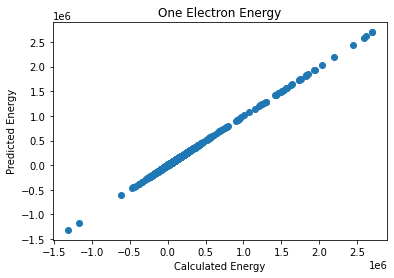

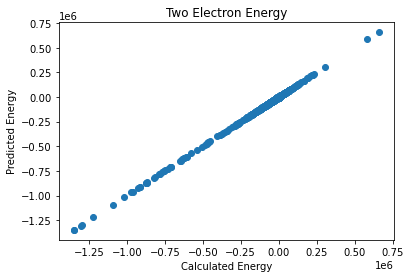

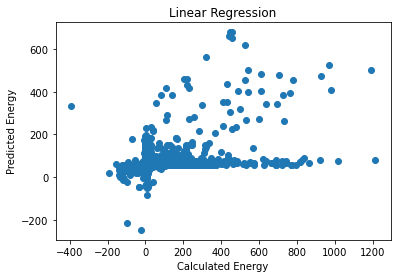

    4.1541    56.1808 172.46
   58.1191    55.3522   4.88
    4.3145    58.8741 172.69
  105.5189    52.9388  66.36
    5.5392    53.7473 162.63
   -8.2744    47.1284 285.19
   25.5121    42.1472  49.17
   30.3548    49.3256  47.62
   63.9076    54.3776  16.11
   83.4313    55.7268  39.82
   41.4216    57.2378  32.06
   22.1734    51.8878  80.24
   24.2986    54.9577  77.37
   31.5317    53.6698  51.97
   38.9583    55.6867  35.35
   22.1560    50.6874  78.34
    4.0272    31.0047 154.02
    4.4597    26.0345 141.50
    6.8991    -3.4921 609.99
   21.0769    58.8391  94.50
  -16.6918    35.2059 560.63
  -14.2981    35.8840 464.95
   -5.7736    36.9118 274.17
   -9.3377    36.7768 336.12
  -10.1578    37.3221 349.57
   -6.6443    37.8545 285.16
  -15.8984    34.4898 542.06
  -18.1346    35.2338 624.22
  -10.5579    36.3914 363.48
    3.1001    25.8901 157.23
    0.7075    19.7922 186.20
    7.2541    24.9666 109.94
   12.8639    25.0911  64.43
    6.5408    19.9755 101.33
    7.9860    

In [6]:
# test two linear models to predict energudiff
# LinearRegression
import sklearn.linear_model as lm
linearNR_Two = lm.LinearRegression()
linearNR_Two.fit(df["PBE_Nuclear_Repulsion"].values.reshape(-1,1), \
                  df["PBE_Two_Electron_Energy"])
print(linearNR_Two.coef_, linearNR_Two.intercept_)
linearNR_One = lm.LinearRegression()
linearNR_One.fit(df["PBE_Nuclear_Repulsion"].values.reshape(-1,1), \
                 df["PBE_One_Electron_Energy"])
print(linearNR_One.coef_, linearNR_One.intercept_)

Onepred = linearNR_One.predict(df["PBE_Nuclear_Repulsion"].values.reshape(-1,1))
Twopred = linearNR_Two.predict(df["PBE_Nuclear_Repulsion"].values.reshape(-1,1))

# scatter plot
plt.clf()
plt.scatter(df["PBE_One_Electron_Energy"], Onepred)
plt.xlabel('Calculated Energy')
plt.ylabel('Predicted Energy')
plt.title('One Electron Energy')
plt.show()

plt.clf()
plt.scatter(df["PBE_Two_Electron_Energy"], Twopred)
plt.xlabel('Calculated Energy')
plt.ylabel('Predicted Energy')
plt.title('Two Electron Energy')
plt.show()

predEnergy = Onepred + Twopred + \
    df["PBE_Nuclear_Repulsion"].values
calculatedEnergy = df["PBE_Nuclear_Repulsion"].values + \
    df["PBE_One_Electron_Energy"].values + \
    df["PBE_Two_Electron_Energy"].values

# scatter plot
plt.clf()
plt.scatter(calculatedEnergy, predEnergy)    
plt.xlabel('Calculated Energy')
plt.ylabel('Predicted Energy')
plt.title('Linear Regression')
plt.show()

for i, ce in enumerate(calculatedEnergy):
    diff = abs(ce - predEnergy[i])/((ce+predEnergy[i])/2.0)
    print("%10.4f %10.4f %6.2f"%(ce, predEnergy[i], diff*100))

# PLSRegression using both one and two electron ?


In [7]:
featurestorms = set()
for tc in top_correlation:
    if tc not in featurestorms:
        for correlated in top_correlation[tc]:
            featurestorms.add(correlated[0])

print ("Features that are correlated with others and to remove")  
for idx, k in enumerate(featurestorms):
    print(idx+1 , " ", k)

Features that are correlated with others and to remove
1   PBE0_E(C)
2   TPSSh_Nuclear_Repulsion
3   PBE_Nuclear_Repulsion
4   TPSSh_Kinetic_Energy
5   TPSSh_FINAL_SINGLE_POINT_ENERGY
6   ZORA_E(C)
7   PBE0_One_Electron_Energy
8   ZORA_Dispersion_correction
9   ZORA_Two_Electron_Energy
10   TPSSh_E(C)
11   TPSSh_One_Electron_Energy
12   ZORA_Potential_Energy
13   PBE0_Nuclear_Repulsion
14   ZORA_FINAL_SINGLE_POINT_ENERGY
15   PBE0_FINAL_SINGLE_POINT_ENERGY
16   PBE0_Kinetic_Energy
17   TPSSh_Dispersion_correction
18   PBE_Two_Electron_Energy
19   TPSSh_E(X)
20   ZORA_One_Electron_Energy
21   PBE0_Two_Electron_Energy
22   ZORA_E(X)
23   PBE0_Potential_Energy
24   TPSSh_Two_Electron_Energy
25   PBE0_E(X)
26   ZORA_Kinetic_Energy
27   ZORA_Nuclear_Repulsion
28   TPSSh_Potential_Energy
29   PBE0_Dispersion_correction


In [8]:
print ("Features TO USE")
idx = 1
for f in allfeatures:
    if f not in featurestorms:
        print(idx, f) 
        idx += 1 

Features TO USE
1 PBE_Potential_Energy
2 PBE_Kinetic_Energy
3 PBE_FINAL_SINGLE_POINT_ENERGY
4 PBE_Dispersion_correction
5 PBE_E(C)
6 PBE_One_Electron_Energy
7 PBE_E(X)


In [9]:
featurestorm = list(featurestorms)

for setname in fullsetnames:
    commonutils.remove_features_fromset(allvalues_perset[setname], \
                                            list(featurestorm), \
                                            methods)

for setname in fullsetnames:
    models_results[setname].fulldescriptors = []
    models_results[setname].labels = []
    for idx, val in enumerate(allvalues_perset[setname]):
        models_results[setname].fulldescriptors.append({})
        for method in methods:
            if method+"_energydiff" in val:
                models_results[setname].fulldescriptors[idx].update(\
                    val[method+"_energydiff"])

        models_results[setname].labels.append(val["label"])

setname = "Full"
X, Y, features_names = \
    commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                 models_results[setname].labels)

df = pd.DataFrame(X, columns=features_names)

Correlation matrix


<AxesSubplot:>

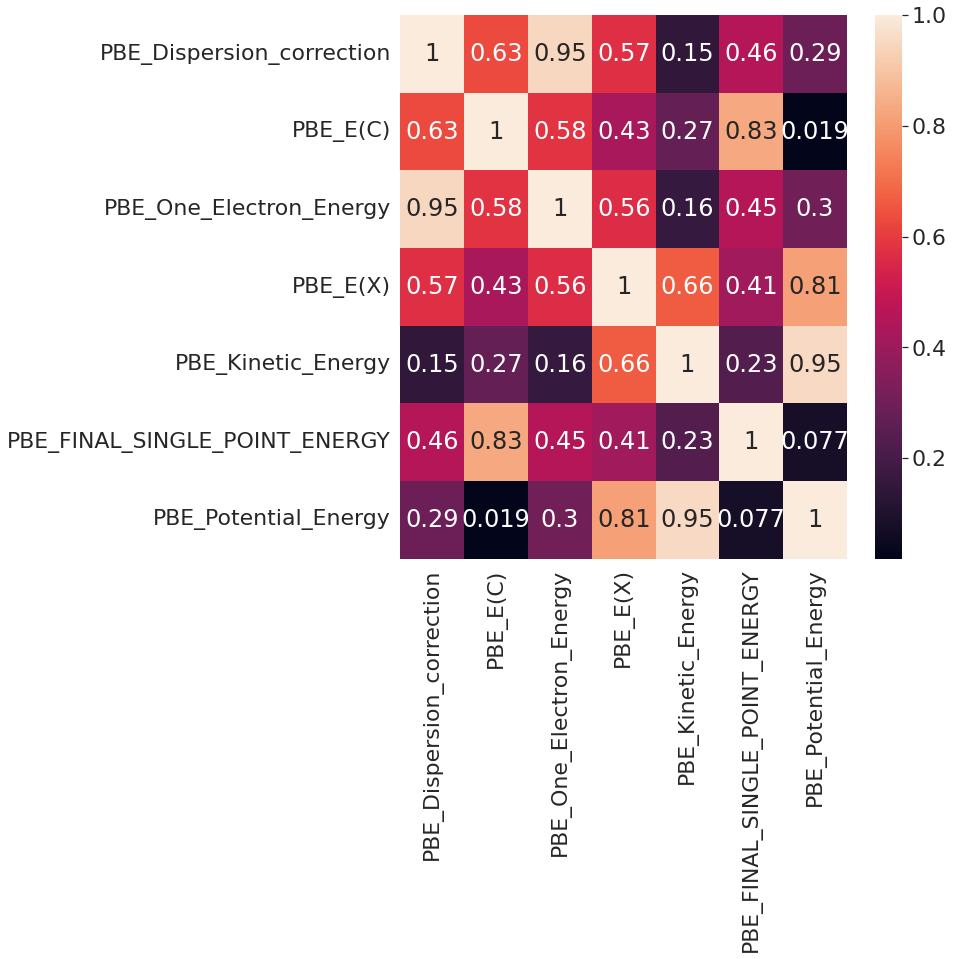

In [10]:
import seaborn as sns
%matplotlib inline
print("Correlation matrix")
plt.rcParams['figure.figsize'] = 10,10
sns.set(font_scale=2)
sns.heatmap(df.corr().abs(), annot=True)
#print(df.corr().abs())
#sns.heatmap(df, annot=True)

In [11]:
# search for the best model a simple grid search
#nepochs = [50, 100]
nepochs = [100]
#batch_sizes = [4, 8, 16, 32]
batch_sizes = [16, 32]
#modelshapes = [[4, 4], [8, 8], [16, 16], \
#                [32, 32], [64, 64], [128, 128], \
#                [4, 4, 4], [8, 8, 8], [16, 16, 16], \
#                [32, 32, 32], [64, 64, 64], \
#                [128, 128, 128], [4, 4, 4, 4], \
#                [8, 8, 8, 8], [16, 16, 16, 16], \
#                [32, 32, 32, 32], [64, 64, 64, 64], \
#                [128, 128, 128, 128]]
modelshapes = [[4, 4, 4], [8, 8, 8], [16, 16, 16], \
                [32, 32, 32], [64, 64, 64], \
                [128, 128, 128], [4, 4, 4, 4], \
                [8, 8, 8, 8], [16, 16, 16, 16], \
                [32, 32, 32, 32], [64, 64, 64, 64], \
                [128, 128, 128, 128], [4, 4, 4, 4, 4], \
                [8, 8, 8, 8, 8], [16, 16, 16, 16, 16], 
                [32, 32, 32, 32, 32], [64, 64, 64, 64, 64],
                [128, 128, 128, 128, 128], [4, 4, 4, 4, 4, 4], \
                [8, 8, 8, 8, 8, 8], [16, 16, 16, 16, 16, 16], 
                [32, 32, 32, 32, 32, 32], [64, 64, 64, 64, 64, 64],
                [128, 128, 128, 128, 128, 128]]
setname = "Full"
X, Y, features_names = \
            commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                    models_results[setname].labels)
scalerx = preprocessing.StandardScaler().fit(X)
X_s = scalerx.transform(X) 
scalery = preprocessing.StandardScaler().fit(Y.reshape(-1, 1))
Y_s = scalery.transform(Y.reshape(-1, 1))
modelminmape, modelminrmse = \
        models.nn_model(0.2, X_s, Y_s, \
                    nepochs, modelshapes, batch_sizes, inputshape=-1,\
                    search=True)
    
print("Best NN model for set: ", setname, file=sys.stderr)
print("  RMSE: ", modelminrmse, file=sys.stderr)
print("  MAPE: ", modelminmape, file=sys.stderr)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


Best NN model for set:  Full
  RMSE:  ([64, 64, 64, 64], 100, 32)
  MAPE:  ([128, 128, 128], 100, 32)


In [12]:
import importlib
importlib.reload(models)

#build the final model and print the results
results_mape = models.nn_model(0.2, X_s, Y_s, \
                    [modelminmape[1]], \
                    [modelminmape[0]], \
                    [modelminmape[2]], \
                    inputshape=-1,\
                    search=False)

results_rmse = models.nn_model(0.2, X_s, Y_s, \
                    [modelminrmse[1]], \
                    [modelminrmse[0]], \
                    [modelminrmse[2]], \
                    inputshape=-1,\
                    search=False)

38/38 [==============================] - 0s 358us/step


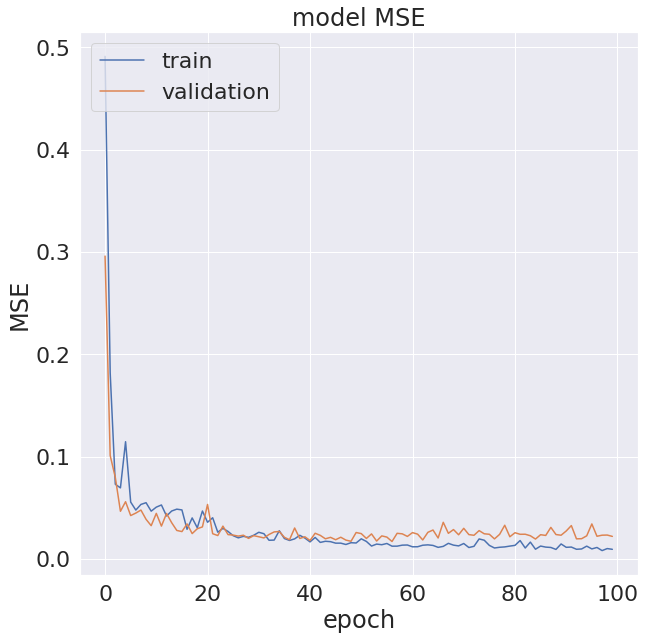

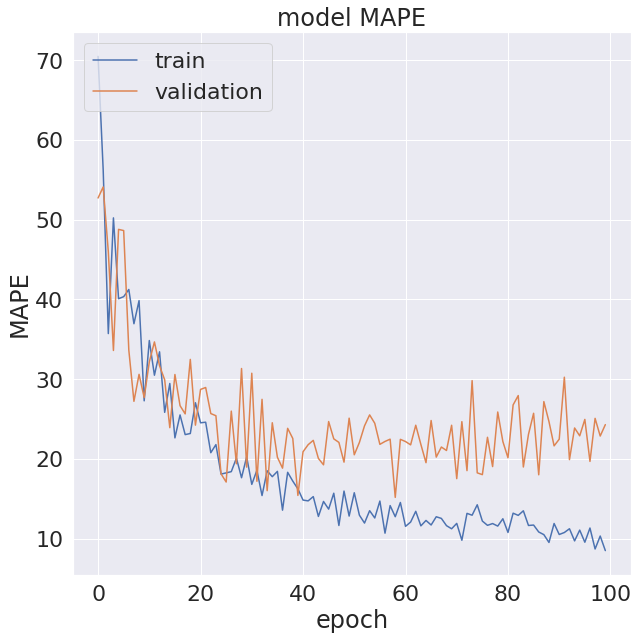

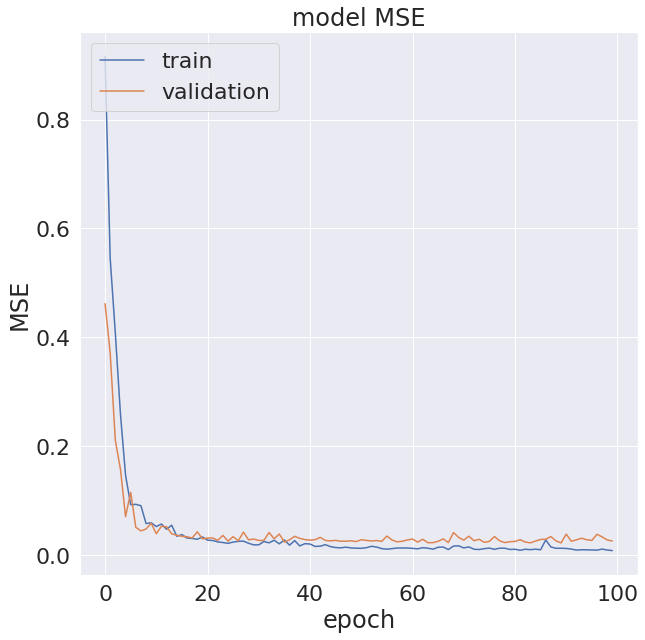

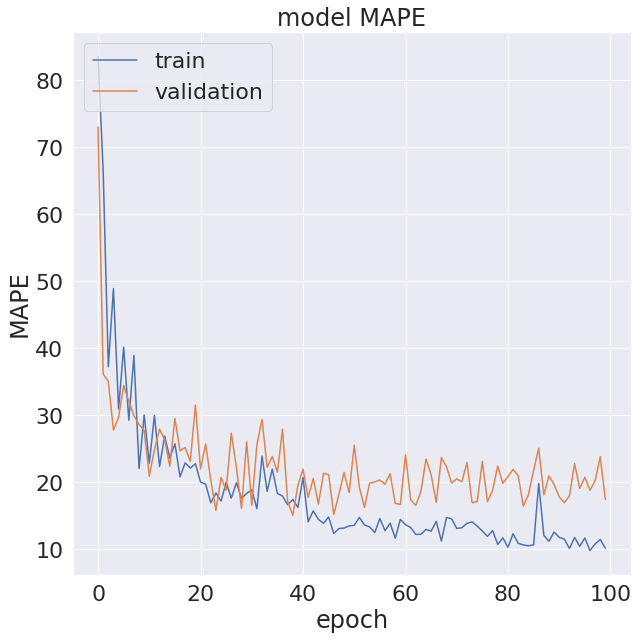

In [13]:
# summarize history for accuracy
history = results_mape['history']
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.title('model MAPE')
plt.ylabel('MAPE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for accuracy
history = results_rmse['history']
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.title('model MAPE')
plt.ylabel('MAPE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


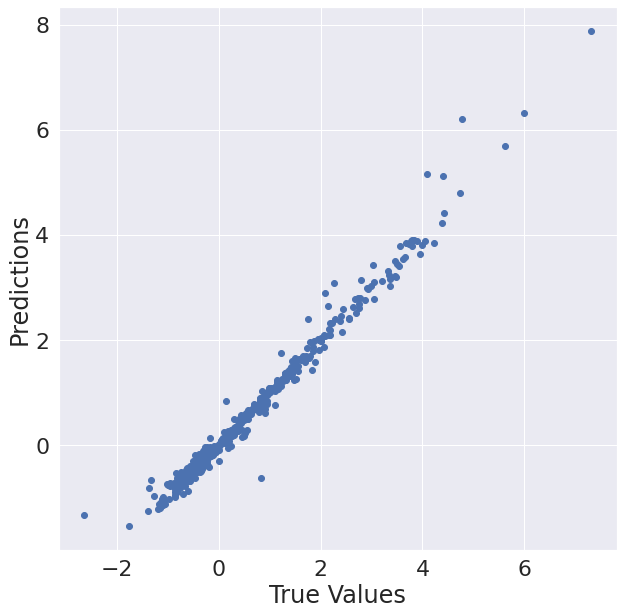

RMSE Full      : 20.14
R2 Full        :  0.99


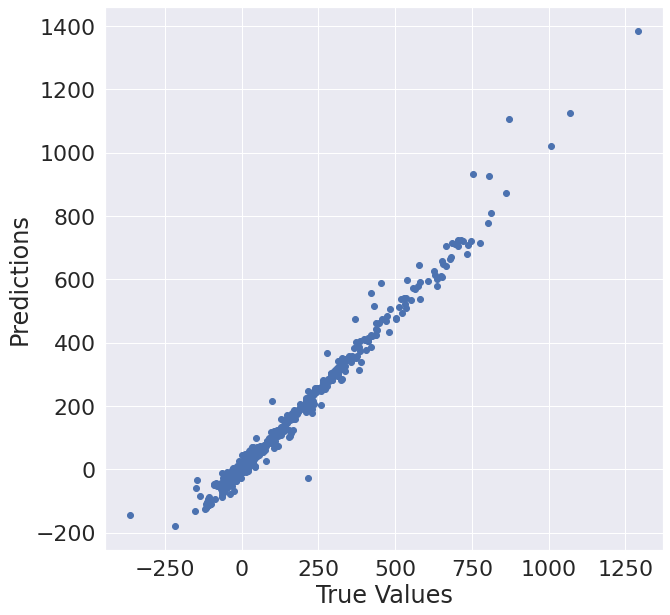

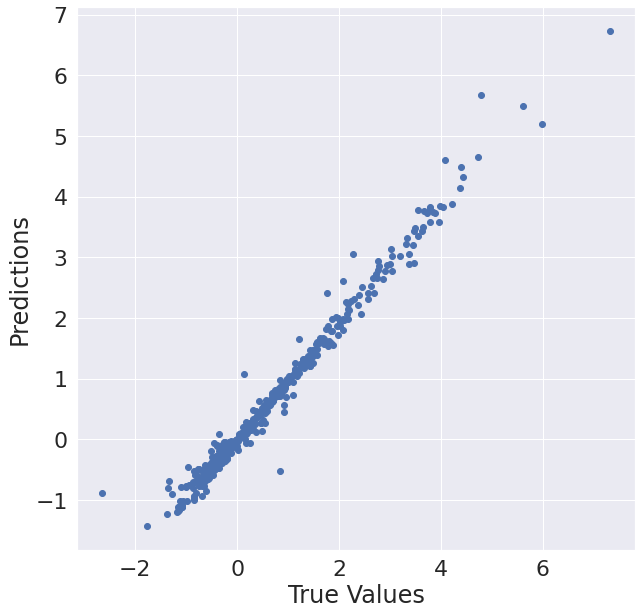

RMSE Full      : 20.23
R2 Full        :  0.99


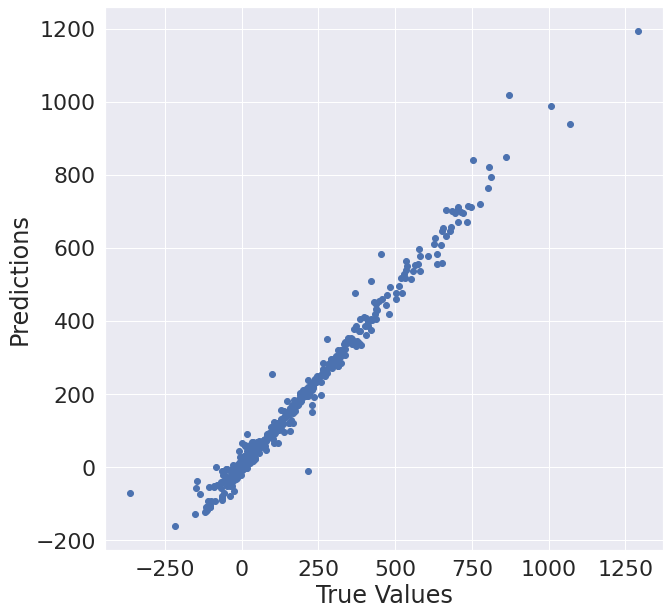

In [14]:
#denomrlize the results
plt.clf()
plt.scatter(results_mape['y_full'], \
            results_mape['y_pred_full'])
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()
y_pred_full = scalery.inverse_transform(results_mape['y_pred_full'])
y_full = scalery.inverse_transform(results_mape['y_full'])
rmse_full = mean_squared_error(y_full, y_pred_full, squared=False)
r2_full = r2_score(y_full, y_pred_full)
print("RMSE Full      : %5.2f"%rmse_full)
print("R2 Full        : %5.2f"%r2_full)

# plot the results
plt.clf()
plt.scatter(y_full, y_pred_full)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

#denomrlize the results
plt.clf()
plt.scatter(results_rmse['y_full'], \
            results_rmse['y_pred_full'])
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()
y_pred_full = scalery.inverse_transform(results_rmse['y_pred_full'])
y_full = scalery.inverse_transform(results_rmse['y_full'])
rmse_full = mean_squared_error(y_full, y_pred_full, squared=False)
r2_full = r2_score(y_full, y_pred_full)
print("RMSE Full      : %5.2f"%rmse_full)
print("R2 Full        : %5.2f"%r2_full)

# plot the results
plt.clf()
plt.scatter(y_full, y_pred_full)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [15]:
from sklearn.metrics import mean_absolute_percentage_error

print(" Dim , %40s"% "Dataset", " , ", \
      "Best inside method RMSE", " , ", \
      "Best our method RMSE", " , ", \
      "RMSE , MAPE, R2")
for setname in fullsetnames:
    X, Y, features_names = \
            commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                    models_results[setname].labels)
    
    X_s = scalerx.transform(X)
    Y_s = scalery.transform(Y.reshape(-1, 1))
    y_pred_mape = scalery.inverse_transform(results_mape['model'].predict(X_s, verbose=0))
    models_results[setname].y_pred_mape = y_pred_mape
    rmse = mean_squared_error(Y, y_pred_mape, squared=False)
    r2 = r2_score(Y, y_pred_mape)
    mape = mean_absolute_percentage_error(Y, y_pred_mape)

    print("%4d , %40s"%(len(models_results[setname].labels), setname), " , ", \
        "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
        "%7.3f"%models_results[setname].bestourmethod_rmse, " , ", \
        "%7.3f"%rmse, " , ", \
        "%7.3f"%mape, " , ", \
        "%7.3f"%r2)


 Dim ,                                  Dataset  ,  Best inside method RMSE  ,  Best our method RMSE  ,  RMSE , MAPE, R2
 118 ,                          BARRIER_HEIGHTS  ,    6.410  ,   21.488  ,    5.548  ,    0.323  ,    0.931
  10 ,                  BARRIER_HEIGHTS_BHDIV10  ,    9.191  ,   14.651  ,    4.501  ,    0.142  ,    0.967
  26 ,                   BARRIER_HEIGHTS_BHPERI  ,    4.407  ,   17.811  ,    5.688  ,    0.275  ,    0.677
  27 ,                  BARRIER_HEIGHTS_BHROT27  ,    0.611  ,    2.686  ,    2.027  ,    0.446  ,    0.840
  24 ,                    BARRIER_HEIGHTS_INV24  ,    2.658  ,    5.711  ,    8.100  ,    0.298  ,    0.877
  13 ,                     BARRIER_HEIGHTS_PX13  ,   11.730  ,   49.956  ,    6.198  ,    0.209  ,    0.809
  18 ,                   BARRIER_HEIGHTS_WCPT18  ,    8.999  ,   24.302  ,    4.738  ,    0.424  ,    0.958
 147 ,              INTRAMOLECULAR_INTERACTIONS  ,    1.137  ,    5.268  ,    3.906  ,    1.774  ,    0.585
  15 ,        I

In [16]:
print(" Dim , %40s"% "Dataset", " , ", \
      "Best inside method RMSE", " , ", \
      "Best our method RMSE", " , ", \
      "RMSE , MAPE, R2")
for setname in fullsetnames:
    X, Y, features_names = \
            commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                    models_results[setname].labels)
    
    X_s = scalerx.transform(X)
    Y_s = scalery.transform(Y.reshape(-1, 1))
    y_pred = scalery.inverse_transform(results_rmse['model'].predict(X_s, verbose=0))
    models_results[setname].y_pred = y_pred
    rmse = mean_squared_error(Y, y_pred, squared=False)
    r2 = r2_score(Y, y_pred)
    mape = mean_absolute_percentage_error(Y, y_pred)

    print("%4d , %40s"%(len(models_results[setname].labels), setname), " , ", \
        "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
        "%7.3f"%models_results[setname].bestourmethod_rmse, " , ", \
        "%7.3f"%rmse, " , ", \
        "%7.3f"%mape, " , ", \
        "%7.3f"%r2)


 Dim ,                                  Dataset  ,  Best inside method RMSE  ,  Best our method RMSE  ,  RMSE , MAPE, R2
 118 ,                          BARRIER_HEIGHTS  ,    6.410  ,   21.488  ,    5.893  ,    0.329  ,    0.922
  10 ,                  BARRIER_HEIGHTS_BHDIV10  ,    9.191  ,   14.651  ,    7.483  ,    0.203  ,    0.910
  26 ,                   BARRIER_HEIGHTS_BHPERI  ,    4.407  ,   17.811  ,    5.596  ,    0.541  ,    0.688
  27 ,                  BARRIER_HEIGHTS_BHROT27  ,    0.611  ,    2.686  ,    1.791  ,    0.367  ,    0.875
  24 ,                    BARRIER_HEIGHTS_INV24  ,    2.658  ,    5.711  ,    5.789  ,    0.184  ,    0.937
  13 ,                     BARRIER_HEIGHTS_PX13  ,   11.730  ,   49.956  ,   10.245  ,    0.366  ,    0.477
  18 ,                   BARRIER_HEIGHTS_WCPT18  ,    8.999  ,   24.302  ,    5.101  ,    0.204  ,    0.951
 147 ,              INTRAMOLECULAR_INTERACTIONS  ,    1.137  ,    5.268  ,    4.143  ,    1.544  ,    0.533
  15 ,        I

RMSE  BARRIER_HEIGHTS  :   5.89
MAPE  BARRIER_HEIGHTS  :   0.33
R2    BARRIER_HEIGHTS  :   0.92
RMSE MAPE BARRIER_HEIGHTS  :   5.55
MAPE MAPE BARRIER_HEIGHTS  :   0.32
R2   MAPE BARRIER_HEIGHTS  :   0.93


<Figure size 720x720 with 0 Axes>

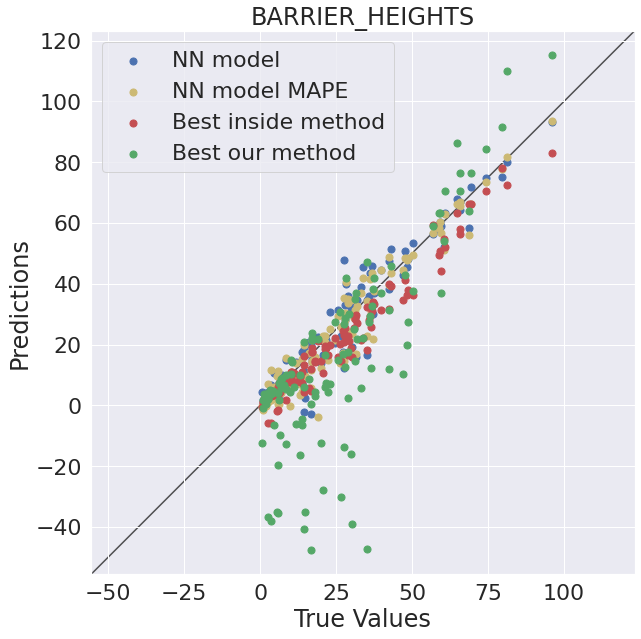

RMSE  BARRIER_HEIGHTS_BHDIV10  :   7.48
MAPE  BARRIER_HEIGHTS_BHDIV10  :   0.20
R2    BARRIER_HEIGHTS_BHDIV10  :   0.91
RMSE MAPE BARRIER_HEIGHTS_BHDIV10  :   4.50
MAPE MAPE BARRIER_HEIGHTS_BHDIV10  :   0.14
R2   MAPE BARRIER_HEIGHTS_BHDIV10  :   0.97


<Figure size 720x720 with 0 Axes>

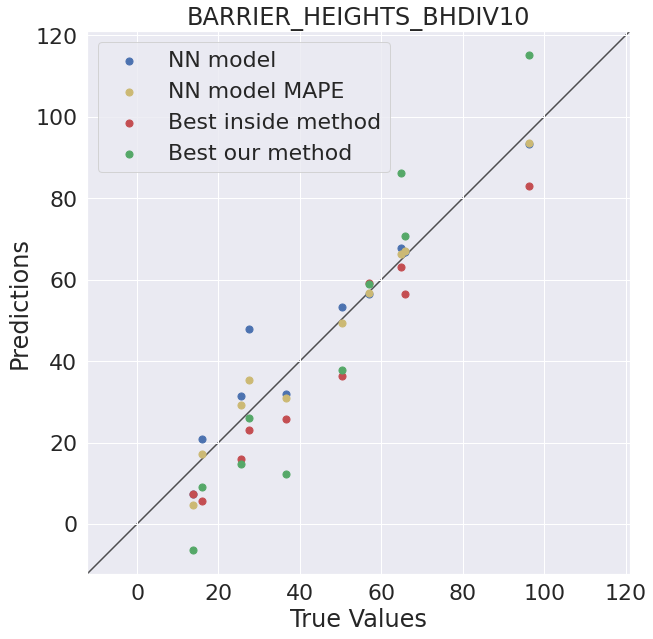

RMSE  BARRIER_HEIGHTS_BHPERI  :   5.60
MAPE  BARRIER_HEIGHTS_BHPERI  :   0.54
R2    BARRIER_HEIGHTS_BHPERI  :   0.69
RMSE MAPE BARRIER_HEIGHTS_BHPERI  :   5.69
MAPE MAPE BARRIER_HEIGHTS_BHPERI  :   0.27
R2   MAPE BARRIER_HEIGHTS_BHPERI  :   0.68


<Figure size 720x720 with 0 Axes>

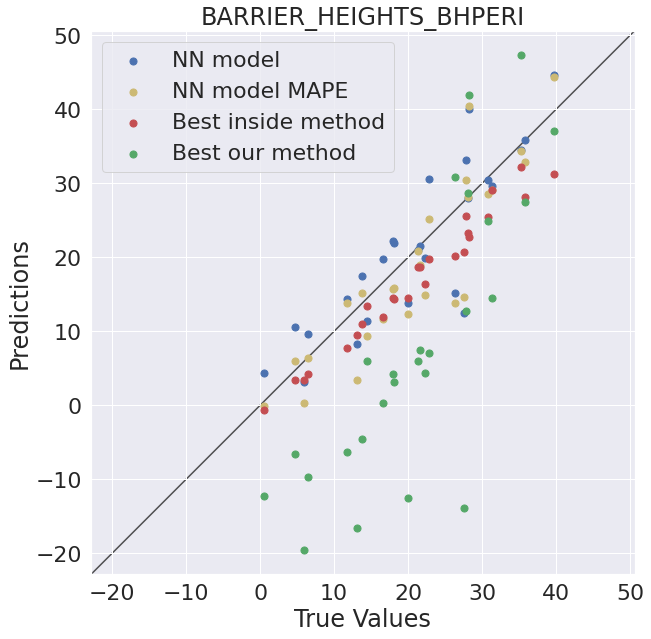

RMSE  BARRIER_HEIGHTS_BHROT27  :   1.79
MAPE  BARRIER_HEIGHTS_BHROT27  :   0.37
R2    BARRIER_HEIGHTS_BHROT27  :   0.88
RMSE MAPE BARRIER_HEIGHTS_BHROT27  :   2.03
MAPE MAPE BARRIER_HEIGHTS_BHROT27  :   0.45
R2   MAPE BARRIER_HEIGHTS_BHROT27  :   0.84


<Figure size 720x720 with 0 Axes>

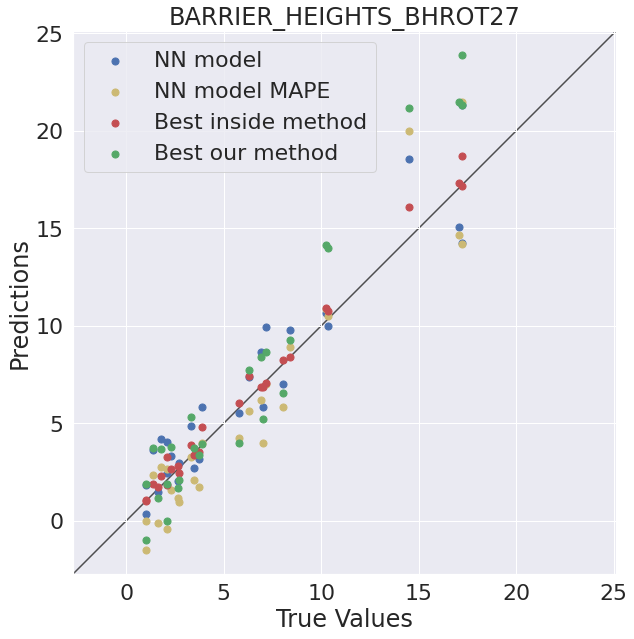

RMSE  BARRIER_HEIGHTS_INV24  :   5.79
MAPE  BARRIER_HEIGHTS_INV24  :   0.18
R2    BARRIER_HEIGHTS_INV24  :   0.94
RMSE MAPE BARRIER_HEIGHTS_INV24  :   8.10
MAPE MAPE BARRIER_HEIGHTS_INV24  :   0.30
R2   MAPE BARRIER_HEIGHTS_INV24  :   0.88


<Figure size 720x720 with 0 Axes>

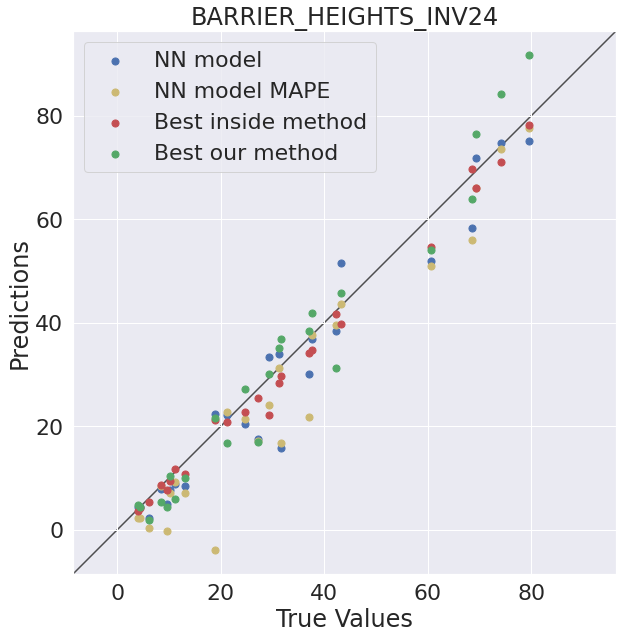

RMSE  BARRIER_HEIGHTS_PX13  :  10.24
MAPE  BARRIER_HEIGHTS_PX13  :   0.37
R2    BARRIER_HEIGHTS_PX13  :   0.48
RMSE MAPE BARRIER_HEIGHTS_PX13  :   6.20
MAPE MAPE BARRIER_HEIGHTS_PX13  :   0.21
R2   MAPE BARRIER_HEIGHTS_PX13  :   0.81


<Figure size 720x720 with 0 Axes>

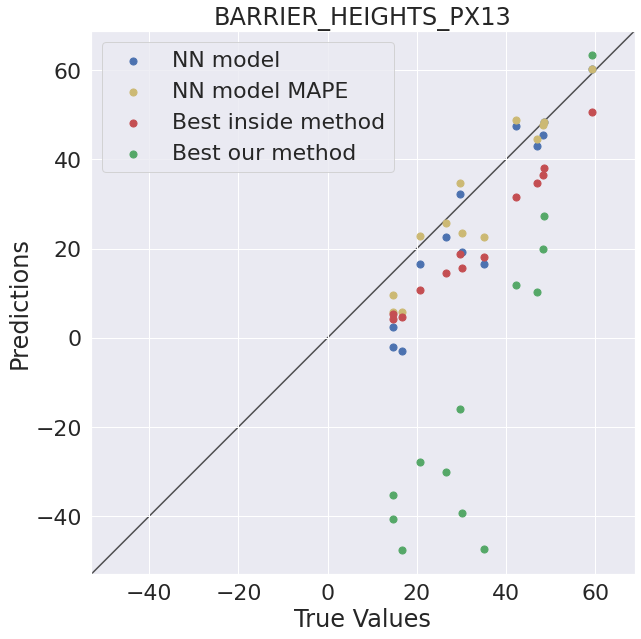

RMSE  BARRIER_HEIGHTS_WCPT18  :   5.10
MAPE  BARRIER_HEIGHTS_WCPT18  :   0.20
R2    BARRIER_HEIGHTS_WCPT18  :   0.95
RMSE MAPE BARRIER_HEIGHTS_WCPT18  :   4.74
MAPE MAPE BARRIER_HEIGHTS_WCPT18  :   0.42
R2   MAPE BARRIER_HEIGHTS_WCPT18  :   0.96


<Figure size 720x720 with 0 Axes>

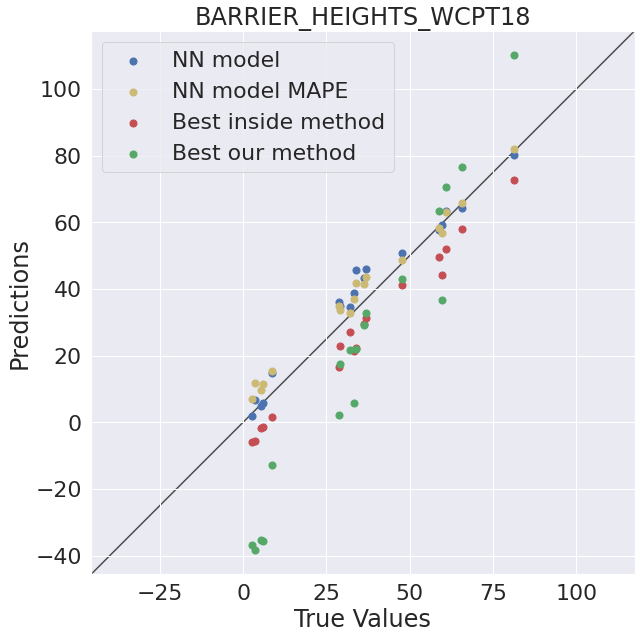

RMSE  INTRAMOLECULAR_INTERACTIONS  :   4.14
MAPE  INTRAMOLECULAR_INTERACTIONS  :   1.54
R2    INTRAMOLECULAR_INTERACTIONS  :   0.53
RMSE MAPE INTRAMOLECULAR_INTERACTIONS  :   3.91
MAPE MAPE INTRAMOLECULAR_INTERACTIONS  :   1.77
R2   MAPE INTRAMOLECULAR_INTERACTIONS  :   0.58


<Figure size 720x720 with 0 Axes>

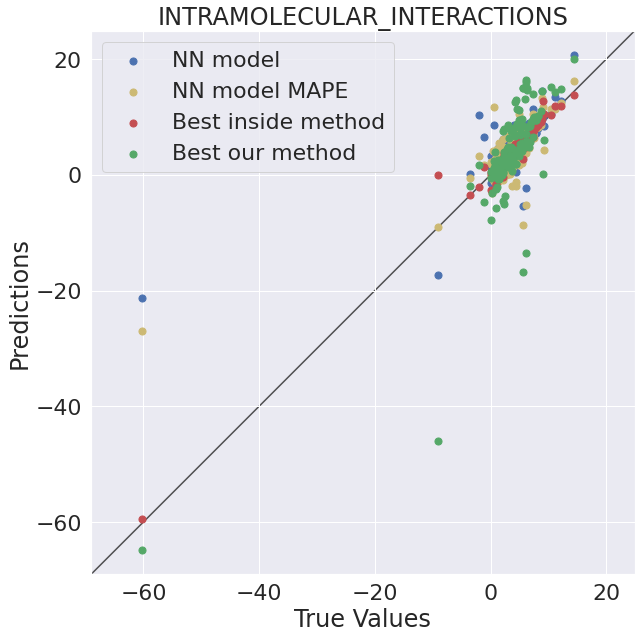

RMSE  INTRAMOLECULAR_INTERACTIONS_ACONF  :   1.92
MAPE  INTRAMOLECULAR_INTERACTIONS_ACONF  :   1.44
R2    INTRAMOLECULAR_INTERACTIONS_ACONF  :  -1.28
RMSE MAPE INTRAMOLECULAR_INTERACTIONS_ACONF  :   2.47
MAPE MAPE INTRAMOLECULAR_INTERACTIONS_ACONF  :   1.82
R2   MAPE INTRAMOLECULAR_INTERACTIONS_ACONF  :  -2.75


<Figure size 720x720 with 0 Axes>

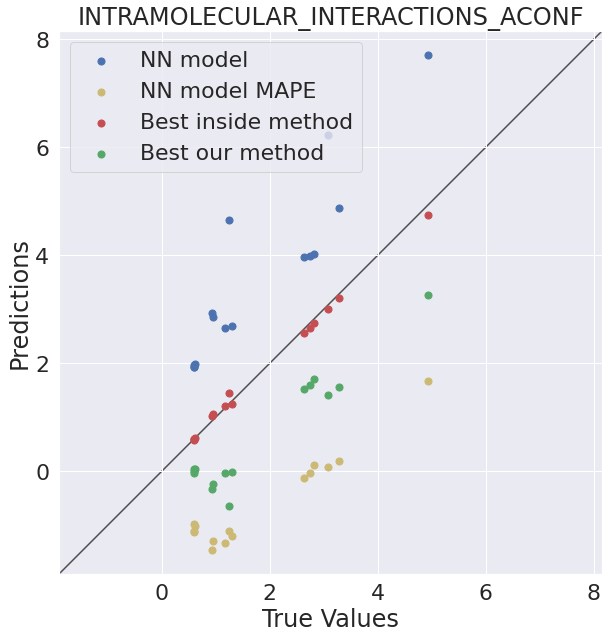

RMSE  INTRAMOLECULAR_INTERACTIONS_ICONF  :   1.94
MAPE  INTRAMOLECULAR_INTERACTIONS_ICONF  :   2.81
R2    INTRAMOLECULAR_INTERACTIONS_ICONF  :   0.62
RMSE MAPE INTRAMOLECULAR_INTERACTIONS_ICONF  :   3.13
MAPE MAPE INTRAMOLECULAR_INTERACTIONS_ICONF  :   2.02
R2   MAPE INTRAMOLECULAR_INTERACTIONS_ICONF  :   0.01


<Figure size 720x720 with 0 Axes>

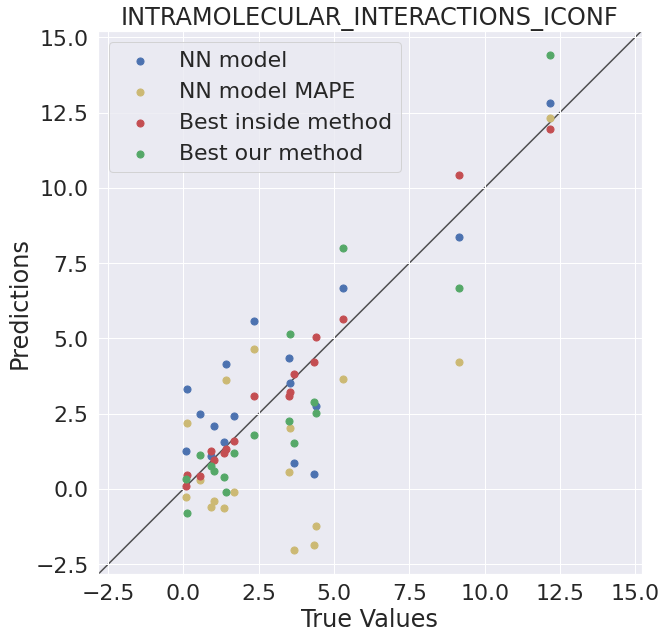

RMSE  INTRAMOLECULAR_INTERACTIONS_IDISP  :  17.37
MAPE  INTRAMOLECULAR_INTERACTIONS_IDISP  :   2.56
R2    INTRAMOLECULAR_INTERACTIONS_IDISP  :   0.41
RMSE MAPE INTRAMOLECULAR_INTERACTIONS_IDISP  :  13.92
MAPE MAPE INTRAMOLECULAR_INTERACTIONS_IDISP  :   1.13
R2   MAPE INTRAMOLECULAR_INTERACTIONS_IDISP  :   0.62


<Figure size 720x720 with 0 Axes>

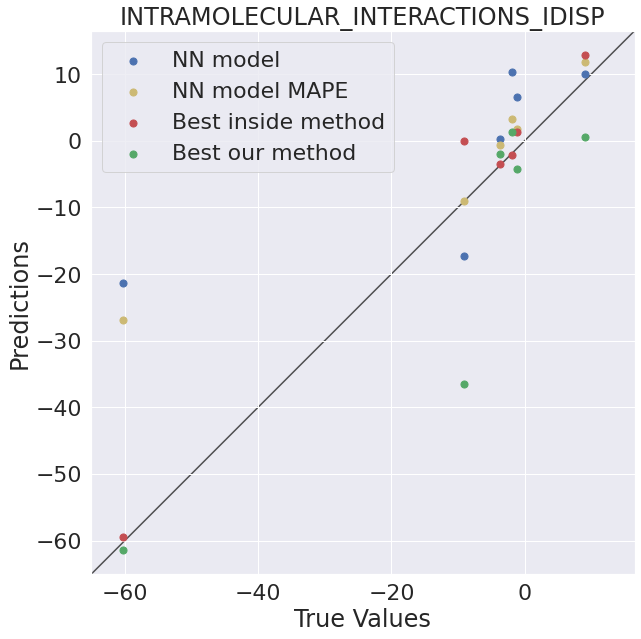

RMSE  INTRAMOLECULAR_INTERACTIONS_MCONF  :   1.06
MAPE  INTRAMOLECULAR_INTERACTIONS_MCONF  :   0.35
R2    INTRAMOLECULAR_INTERACTIONS_MCONF  :   0.72
RMSE MAPE INTRAMOLECULAR_INTERACTIONS_MCONF  :   1.44
MAPE MAPE INTRAMOLECULAR_INTERACTIONS_MCONF  :   0.48
R2   MAPE INTRAMOLECULAR_INTERACTIONS_MCONF  :   0.48


<Figure size 720x720 with 0 Axes>

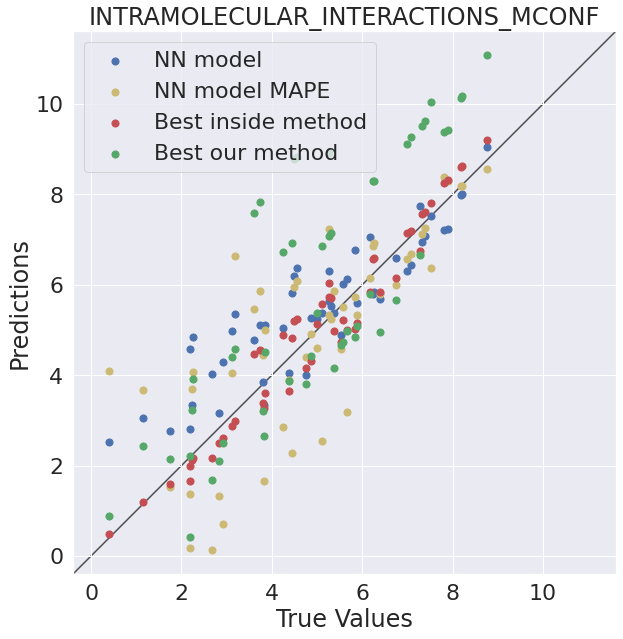

RMSE  INTRAMOLECULAR_INTERACTIONS_PCONF21  :   1.56
MAPE  INTRAMOLECULAR_INTERACTIONS_PCONF21  :   4.79
R2    INTRAMOLECULAR_INTERACTIONS_PCONF21  :  -3.25
RMSE MAPE INTRAMOLECULAR_INTERACTIONS_PCONF21  :   1.98
MAPE MAPE INTRAMOLECULAR_INTERACTIONS_PCONF21  :   6.15
R2   MAPE INTRAMOLECULAR_INTERACTIONS_PCONF21  :  -5.91


<Figure size 720x720 with 0 Axes>

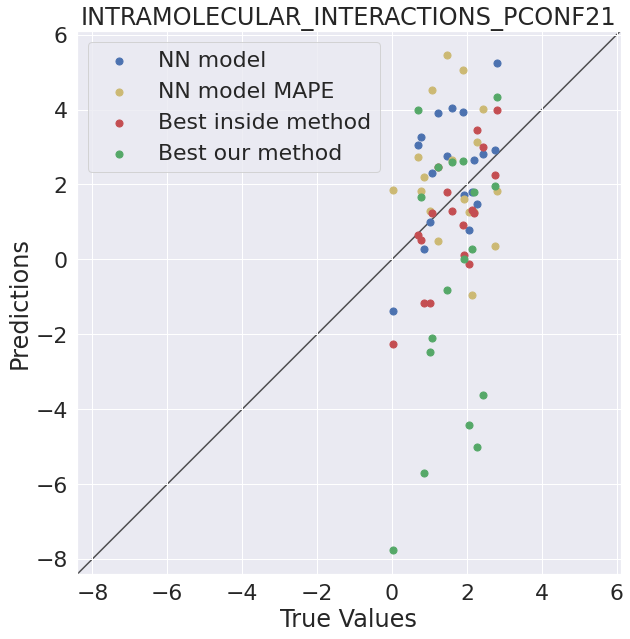

RMSE  INTRAMOLECULAR_INTERACTIONS_SCONF  :   3.81
MAPE  INTRAMOLECULAR_INTERACTIONS_SCONF  :   0.79
R2    INTRAMOLECULAR_INTERACTIONS_SCONF  :  -3.17
RMSE MAPE INTRAMOLECULAR_INTERACTIONS_SCONF  :   4.67
MAPE MAPE INTRAMOLECULAR_INTERACTIONS_SCONF  :   1.53
R2   MAPE INTRAMOLECULAR_INTERACTIONS_SCONF  :  -5.28


<Figure size 720x720 with 0 Axes>

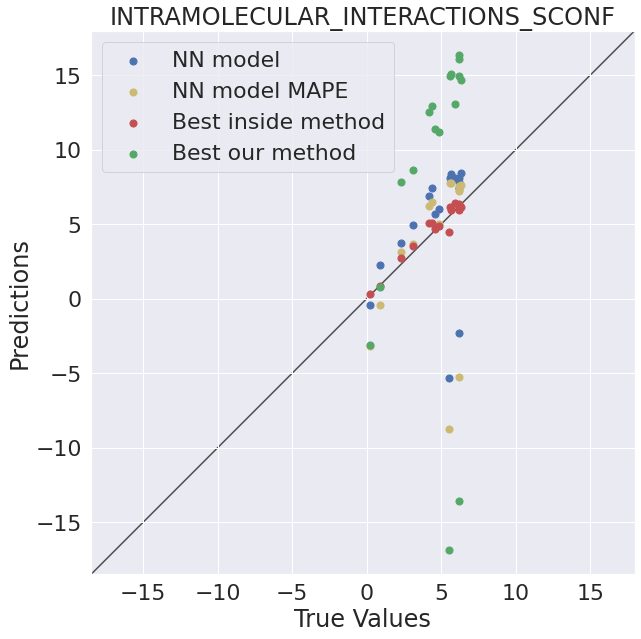

RMSE  INTRAMOLECULAR_INTERACTIONS_UPU23  :   3.27
MAPE  INTRAMOLECULAR_INTERACTIONS_UPU23  :   1.08
R2    INTRAMOLECULAR_INTERACTIONS_UPU23  :  -0.10
RMSE MAPE INTRAMOLECULAR_INTERACTIONS_UPU23  :   3.46
MAPE MAPE INTRAMOLECULAR_INTERACTIONS_UPU23  :   1.34
R2   MAPE INTRAMOLECULAR_INTERACTIONS_UPU23  :  -0.24


<Figure size 720x720 with 0 Axes>

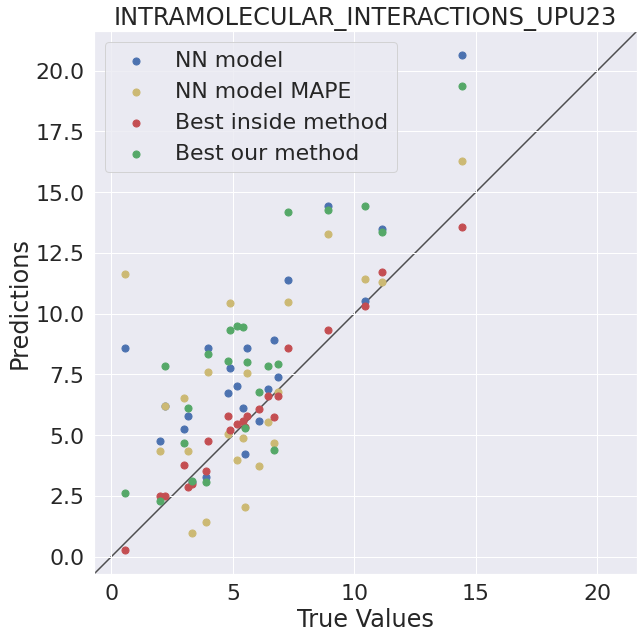

RMSE  SMALL_MOLECULES  :  20.59
MAPE  SMALL_MOLECULES  :   1.39
R2    SMALL_MOLECULES  :   0.99
RMSE MAPE SMALL_MOLECULES  :  18.99
MAPE MAPE SMALL_MOLECULES  :   1.16
R2   MAPE SMALL_MOLECULES  :   0.99


<Figure size 720x720 with 0 Axes>

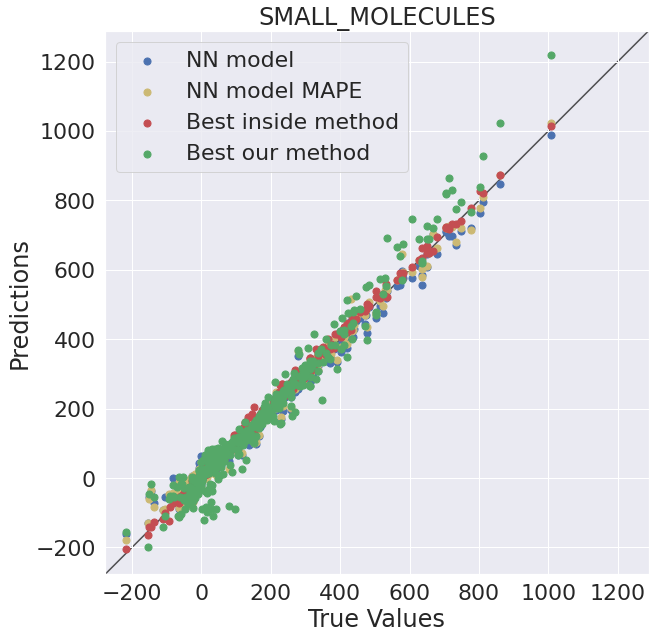

RMSE  SMALL_MOLECULES_AL2X6  :   5.60
MAPE  SMALL_MOLECULES_AL2X6  :   0.14
R2    SMALL_MOLECULES_AL2X6  :   0.59
RMSE MAPE SMALL_MOLECULES_AL2X6  :   5.92
MAPE MAPE SMALL_MOLECULES_AL2X6  :   0.11
R2   MAPE SMALL_MOLECULES_AL2X6  :   0.54


<Figure size 720x720 with 0 Axes>

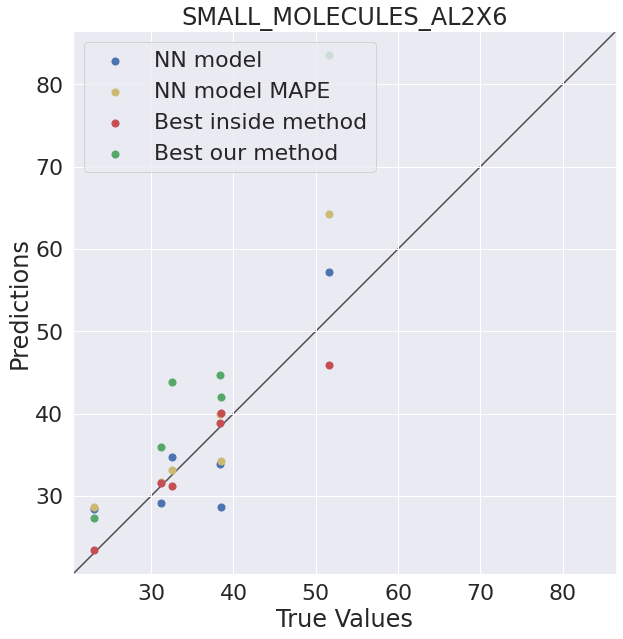

RMSE  SMALL_MOLECULES_ALK8  :   6.00
MAPE  SMALL_MOLECULES_ALK8  :   0.08
R2    SMALL_MOLECULES_ALK8  :   0.96
RMSE MAPE SMALL_MOLECULES_ALK8  :   6.16
MAPE MAPE SMALL_MOLECULES_ALK8  :   0.06
R2   MAPE SMALL_MOLECULES_ALK8  :   0.96


<Figure size 720x720 with 0 Axes>

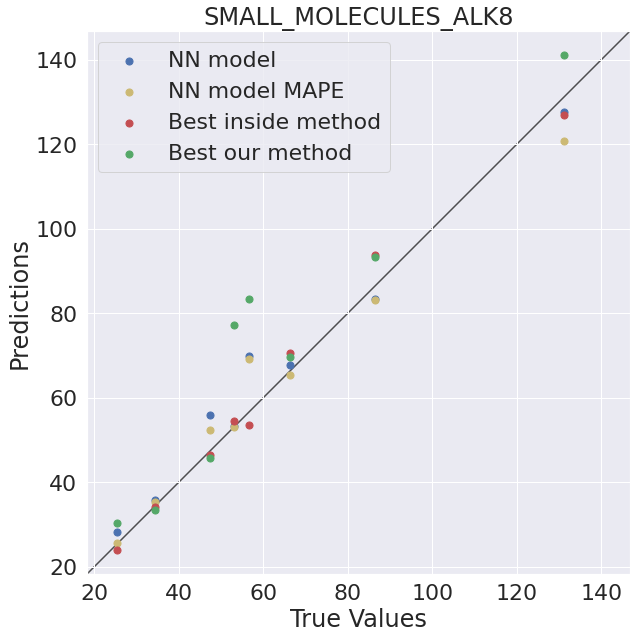

RMSE  SMALL_MOLECULES_ALKBDE10  :  17.15
MAPE  SMALL_MOLECULES_ALKBDE10  :   0.09
R2    SMALL_MOLECULES_ALKBDE10  :   0.71
RMSE MAPE SMALL_MOLECULES_ALKBDE10  :  15.72
MAPE MAPE SMALL_MOLECULES_ALKBDE10  :   0.09
R2   MAPE SMALL_MOLECULES_ALKBDE10  :   0.75


<Figure size 720x720 with 0 Axes>

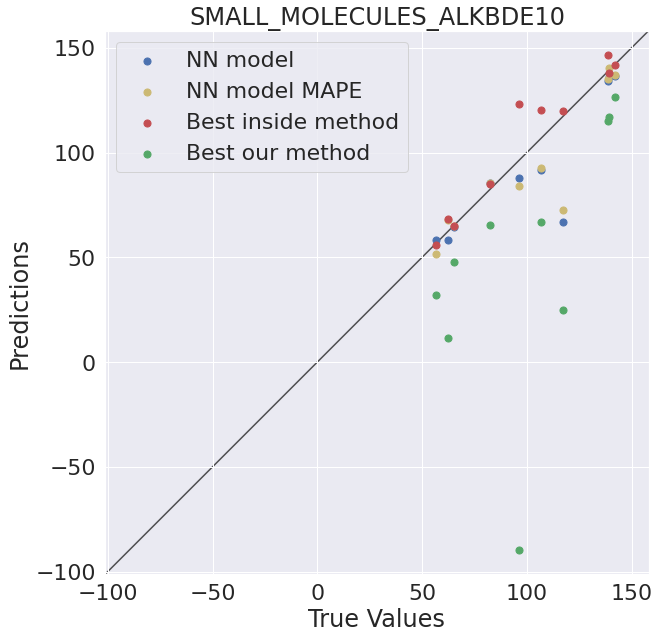

RMSE  SMALL_MOLECULES_DC13  :  25.79
MAPE  SMALL_MOLECULES_DC13  :   0.82
R2    SMALL_MOLECULES_DC13  :   0.86
RMSE MAPE SMALL_MOLECULES_DC13  :  23.09
MAPE MAPE SMALL_MOLECULES_DC13  :   0.64
R2   MAPE SMALL_MOLECULES_DC13  :   0.89


<Figure size 720x720 with 0 Axes>

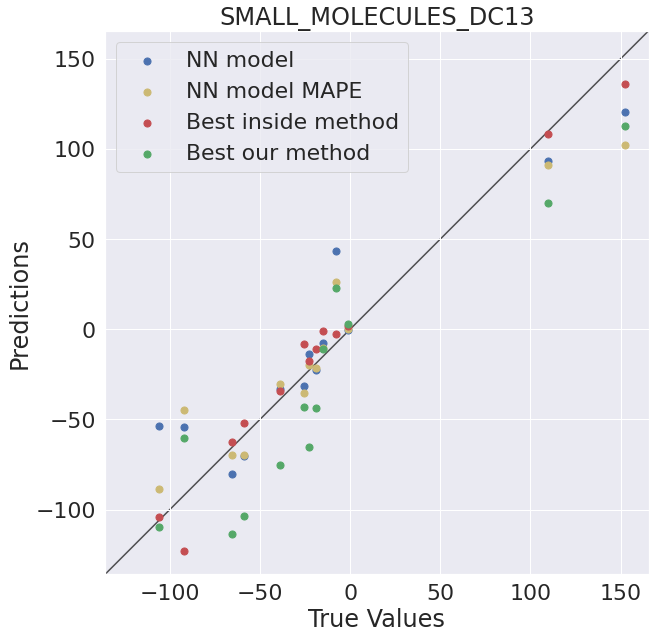

RMSE  SMALL_MOLECULES_DIPCS10  :  44.25
MAPE  SMALL_MOLECULES_DIPCS10  :   0.06
R2    SMALL_MOLECULES_DIPCS10  :   0.70
RMSE MAPE SMALL_MOLECULES_DIPCS10  :  37.80
MAPE MAPE SMALL_MOLECULES_DIPCS10  :   0.05
R2   MAPE SMALL_MOLECULES_DIPCS10  :   0.78


<Figure size 720x720 with 0 Axes>

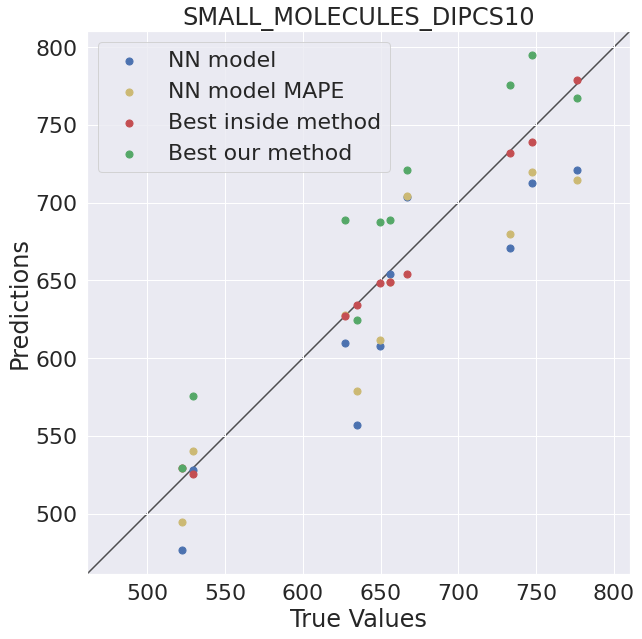

RMSE  SMALL_MOLECULES_FH51  :  28.37
MAPE  SMALL_MOLECULES_FH51  :   2.24
R2    SMALL_MOLECULES_FH51  :   0.27
RMSE MAPE SMALL_MOLECULES_FH51  :  26.27
MAPE MAPE SMALL_MOLECULES_FH51  :   1.89
R2   MAPE SMALL_MOLECULES_FH51  :   0.37


<Figure size 720x720 with 0 Axes>

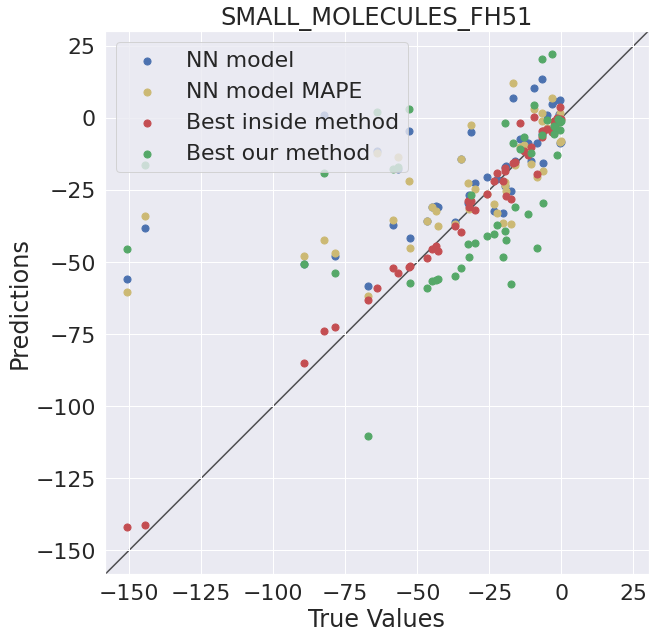

RMSE  SMALL_MOLECULES_G21EA  :  21.22
MAPE  SMALL_MOLECULES_G21EA  :  13.76
R2    SMALL_MOLECULES_G21EA  :   0.17
RMSE MAPE SMALL_MOLECULES_G21EA  :  19.70
MAPE MAPE SMALL_MOLECULES_G21EA  :  10.04
R2   MAPE SMALL_MOLECULES_G21EA  :   0.28


<Figure size 720x720 with 0 Axes>

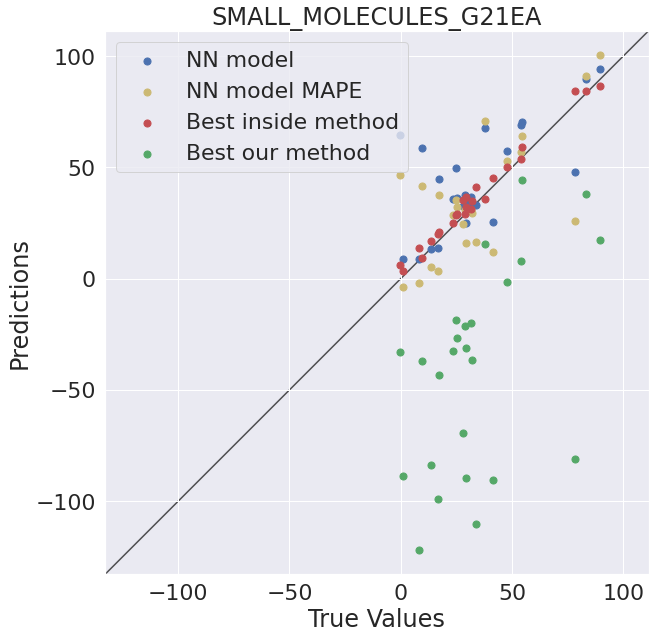

RMSE  SMALL_MOLECULES_G21IP  :  17.42
MAPE  SMALL_MOLECULES_G21IP  :   0.04
R2    SMALL_MOLECULES_G21IP  :   0.93
RMSE MAPE SMALL_MOLECULES_G21IP  :  18.64
MAPE MAPE SMALL_MOLECULES_G21IP  :   0.04
R2   MAPE SMALL_MOLECULES_G21IP  :   0.91


<Figure size 720x720 with 0 Axes>

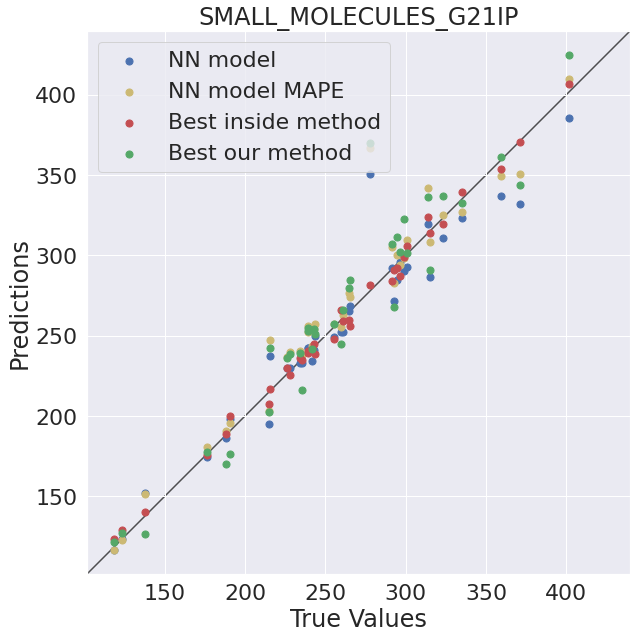

RMSE  SMALL_MOLECULES_G2RC  :  28.01
MAPE  SMALL_MOLECULES_G2RC  :   1.51
R2    SMALL_MOLECULES_G2RC  :   0.71
RMSE MAPE SMALL_MOLECULES_G2RC  :  25.03
MAPE MAPE SMALL_MOLECULES_G2RC  :   1.70
R2   MAPE SMALL_MOLECULES_G2RC  :   0.77


<Figure size 720x720 with 0 Axes>

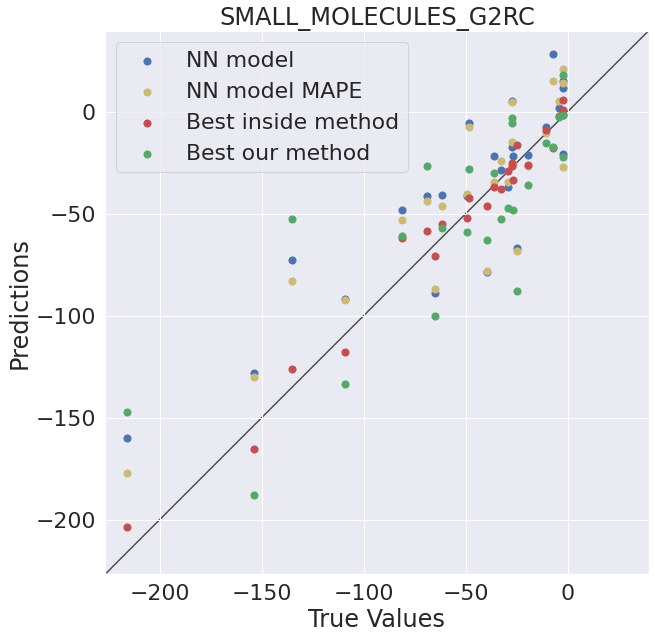

RMSE  SMALL_MOLECULES_NBPRC  :   8.04
MAPE  SMALL_MOLECULES_NBPRC  :   0.69
R2    SMALL_MOLECULES_NBPRC  :   0.93
RMSE MAPE SMALL_MOLECULES_NBPRC  :   6.33
MAPE MAPE SMALL_MOLECULES_NBPRC  :   0.45
R2   MAPE SMALL_MOLECULES_NBPRC  :   0.95


<Figure size 720x720 with 0 Axes>

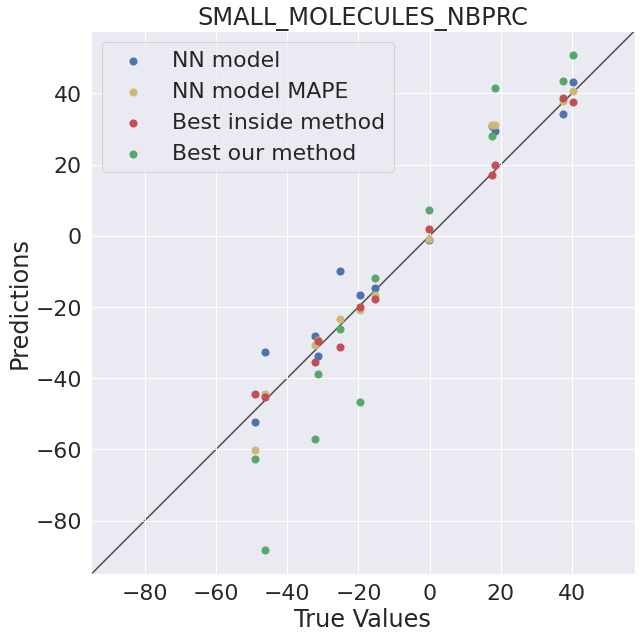

RMSE  SMALL_MOLECULES_PA26  :  20.44
MAPE  SMALL_MOLECULES_PA26  :   0.09
R2    SMALL_MOLECULES_PA26  :   0.60
RMSE MAPE SMALL_MOLECULES_PA26  :  17.25
MAPE MAPE SMALL_MOLECULES_PA26  :   0.07
R2   MAPE SMALL_MOLECULES_PA26  :   0.72


<Figure size 720x720 with 0 Axes>

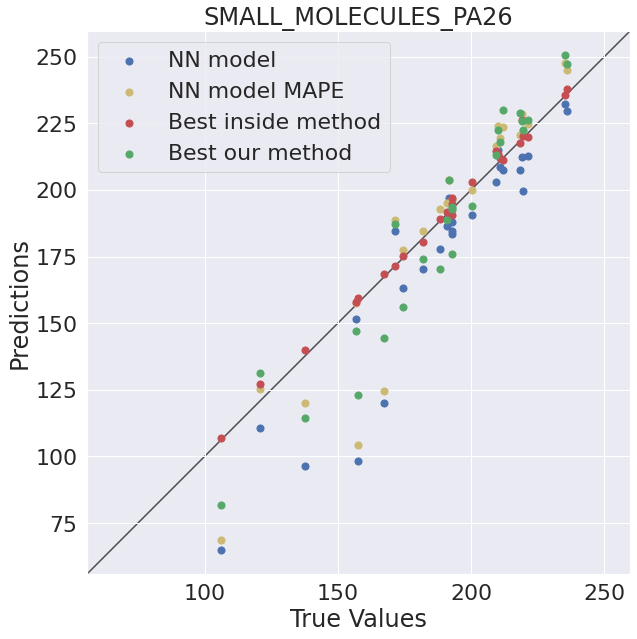

RMSE  SMALL_MOLECULES_RC21  :  12.38
MAPE  SMALL_MOLECULES_RC21  :   1.48
R2    SMALL_MOLECULES_RC21  :   0.78
RMSE MAPE SMALL_MOLECULES_RC21  :  13.01
MAPE MAPE SMALL_MOLECULES_RC21  :   1.19
R2   MAPE SMALL_MOLECULES_RC21  :   0.76


<Figure size 720x720 with 0 Axes>

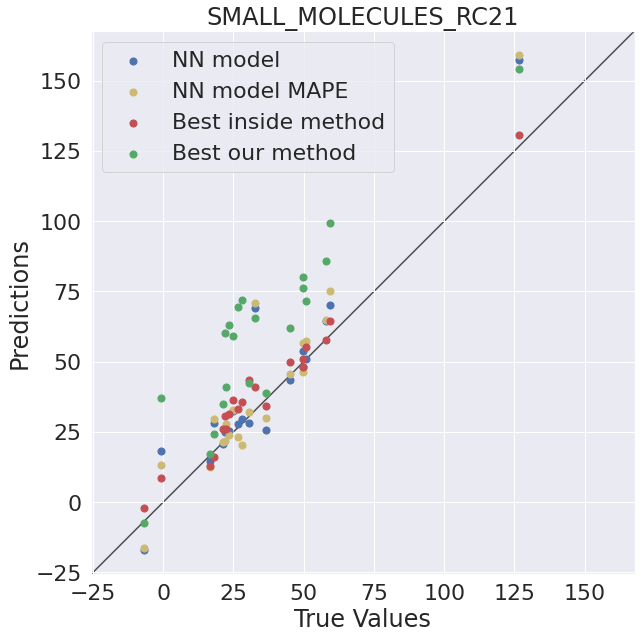

RMSE  SMALL_MOLECULES_SIE4x4  :  10.28
MAPE  SMALL_MOLECULES_SIE4x4  :   0.56
R2    SMALL_MOLECULES_SIE4x4  :   0.66
RMSE MAPE SMALL_MOLECULES_SIE4x4  :  13.73
MAPE MAPE SMALL_MOLECULES_SIE4x4  :   0.81
R2   MAPE SMALL_MOLECULES_SIE4x4  :   0.40


<Figure size 720x720 with 0 Axes>

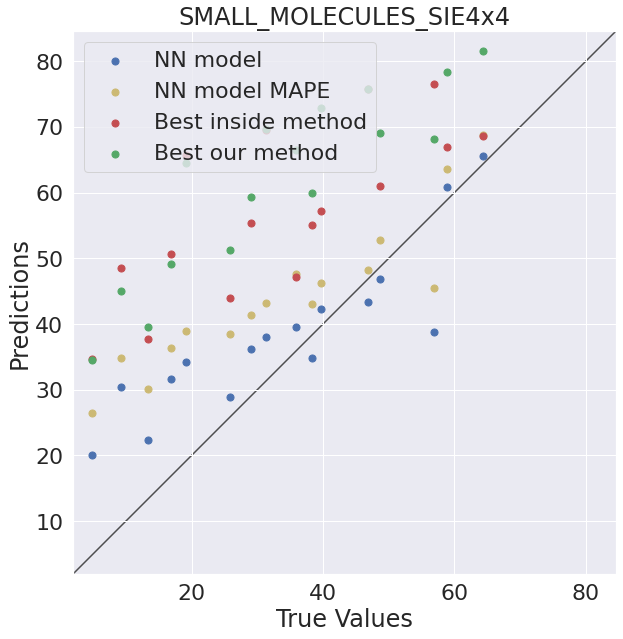

RMSE  SMALL_MOLECULES_TAUT15  :   6.36
MAPE  SMALL_MOLECULES_TAUT15  :   2.05
R2    SMALL_MOLECULES_TAUT15  :  -1.54
RMSE MAPE SMALL_MOLECULES_TAUT15  :   7.06
MAPE MAPE SMALL_MOLECULES_TAUT15  :   2.86
R2   MAPE SMALL_MOLECULES_TAUT15  :  -2.13


<Figure size 720x720 with 0 Axes>

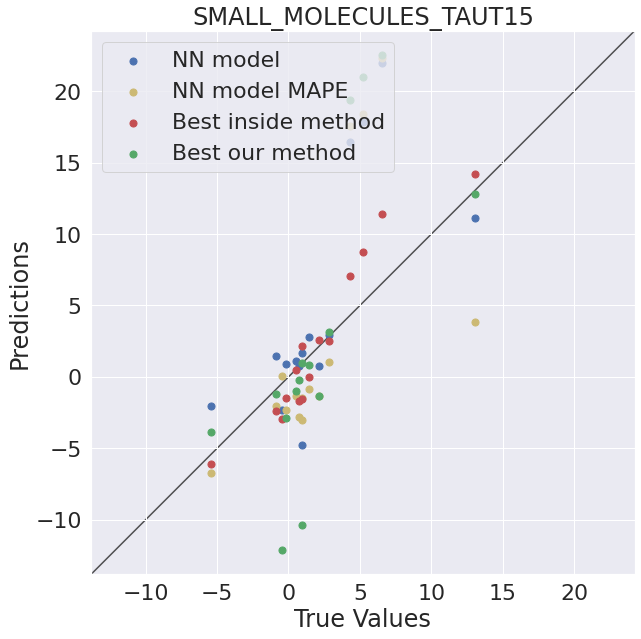

RMSE  SMALL_MOLECULES_W4-11  :  19.04
MAPE  SMALL_MOLECULES_W4-11  :   0.05
R2    SMALL_MOLECULES_W4-11  :   0.99
RMSE MAPE SMALL_MOLECULES_W4-11  :  17.16
MAPE MAPE SMALL_MOLECULES_W4-11  :   0.04
R2   MAPE SMALL_MOLECULES_W4-11  :   0.99


<Figure size 720x720 with 0 Axes>

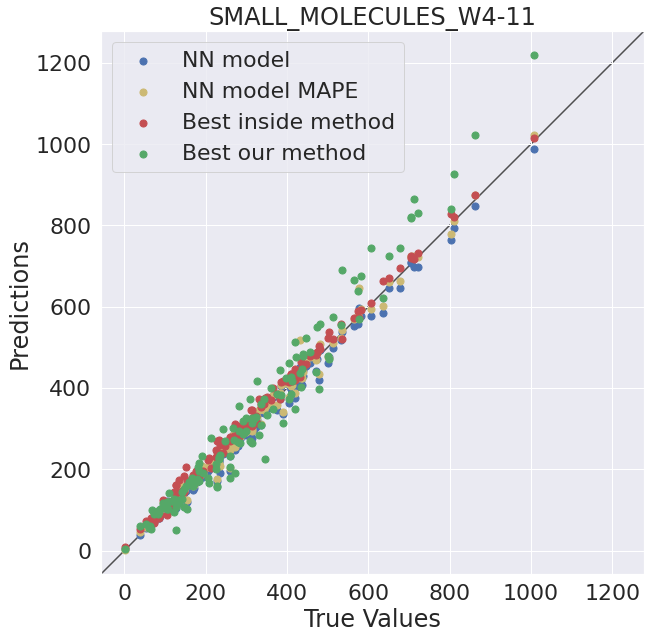

RMSE  SMALL_MOLECULES_YBDE18  :   6.69
MAPE  SMALL_MOLECULES_YBDE18  :   0.11
R2    SMALL_MOLECULES_YBDE18  :   0.89
RMSE MAPE SMALL_MOLECULES_YBDE18  :   9.89
MAPE MAPE SMALL_MOLECULES_YBDE18  :   0.15
R2   MAPE SMALL_MOLECULES_YBDE18  :   0.75


<Figure size 720x720 with 0 Axes>

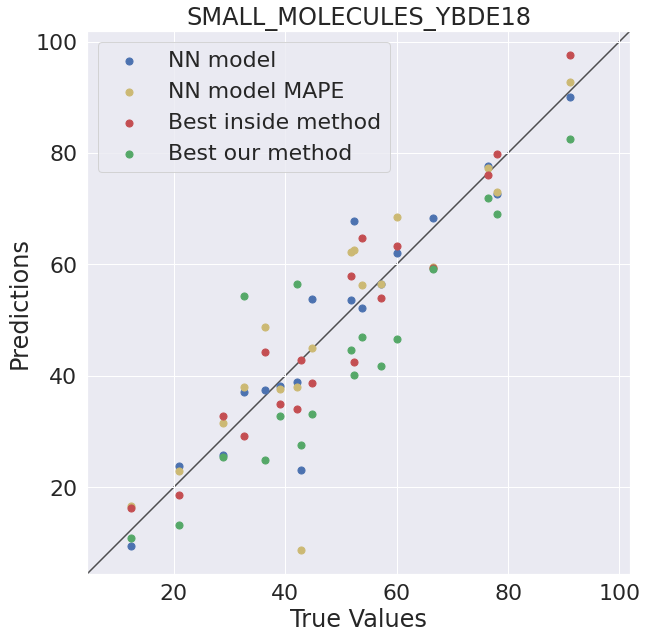

RMSE  INTERMOLECULAR_INTERACTIONS  :   6.55
MAPE  INTERMOLECULAR_INTERACTIONS  :   0.84
R2    INTERMOLECULAR_INTERACTIONS  :   0.98
RMSE MAPE INTERMOLECULAR_INTERACTIONS  :   5.35
MAPE MAPE INTERMOLECULAR_INTERACTIONS  :   0.59
R2   MAPE INTERMOLECULAR_INTERACTIONS  :   0.98


<Figure size 720x720 with 0 Axes>

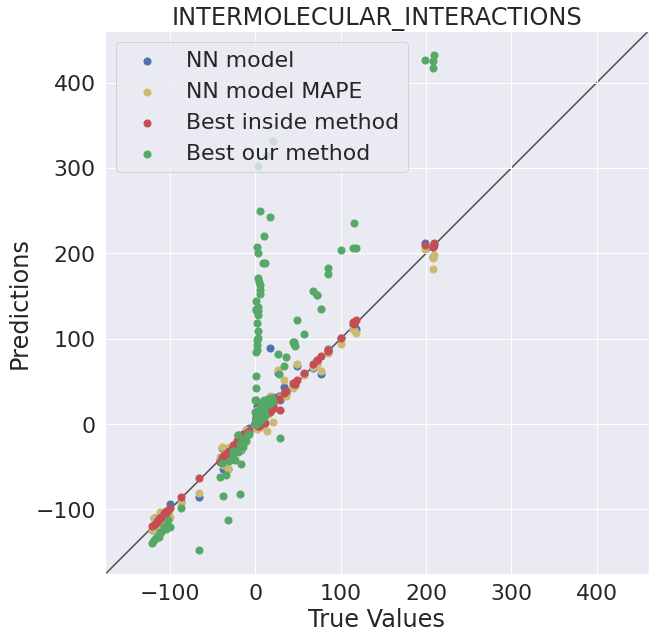

RMSE  INTERMOLECULAR_INTERACTIONS_ADIM6  :   1.12
MAPE  INTERMOLECULAR_INTERACTIONS_ADIM6  :   0.39
R2    INTERMOLECULAR_INTERACTIONS_ADIM6  :   0.41
RMSE MAPE INTERMOLECULAR_INTERACTIONS_ADIM6  :   0.92
MAPE MAPE INTERMOLECULAR_INTERACTIONS_ADIM6  :   0.38
R2   MAPE INTERMOLECULAR_INTERACTIONS_ADIM6  :   0.60


<Figure size 720x720 with 0 Axes>

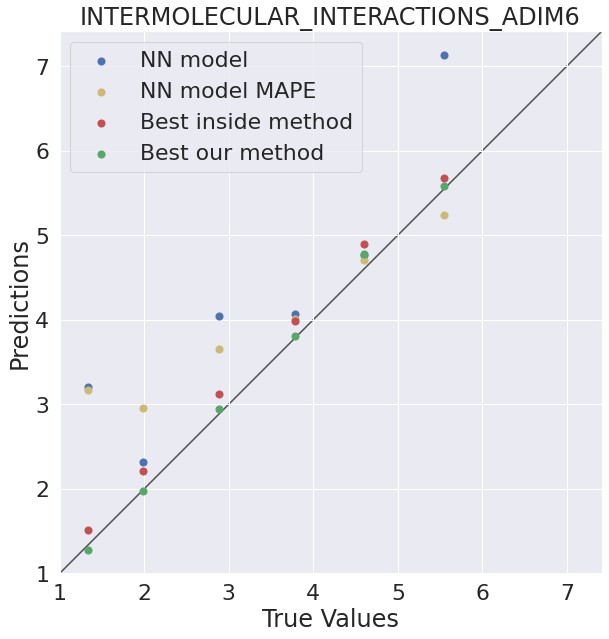

RMSE  INTERMOLECULAR_INTERACTIONS_AHB21  :   7.99
MAPE  INTERMOLECULAR_INTERACTIONS_AHB21  :   0.22
R2    INTERMOLECULAR_INTERACTIONS_AHB21  :   0.64
RMSE MAPE INTERMOLECULAR_INTERACTIONS_AHB21  :   7.73
MAPE MAPE INTERMOLECULAR_INTERACTIONS_AHB21  :   0.30
R2   MAPE INTERMOLECULAR_INTERACTIONS_AHB21  :   0.67


<Figure size 720x720 with 0 Axes>

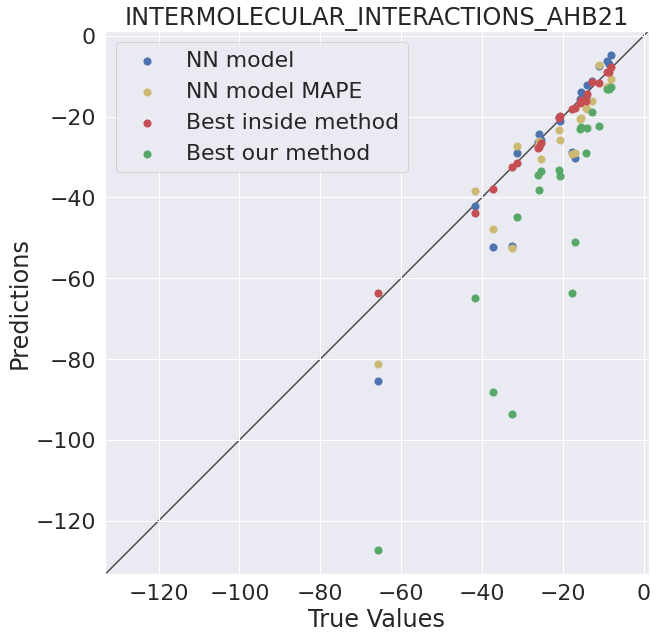

RMSE  INTERMOLECULAR_INTERACTIONS_CARBHB12  :   3.01
MAPE  INTERMOLECULAR_INTERACTIONS_CARBHB12  :   0.33
R2    INTERMOLECULAR_INTERACTIONS_CARBHB12  :   0.49
RMSE MAPE INTERMOLECULAR_INTERACTIONS_CARBHB12  :   1.98
MAPE MAPE INTERMOLECULAR_INTERACTIONS_CARBHB12  :   0.20
R2   MAPE INTERMOLECULAR_INTERACTIONS_CARBHB12  :   0.78


<Figure size 720x720 with 0 Axes>

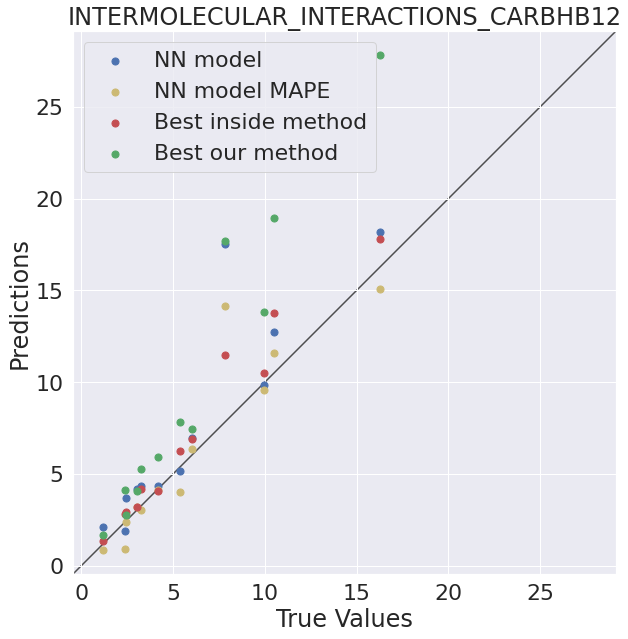

RMSE  INTERMOLECULAR_INTERACTIONS_CHB6  :   6.85
MAPE  INTERMOLECULAR_INTERACTIONS_CHB6  :   0.22
R2    INTERMOLECULAR_INTERACTIONS_CHB6  :   0.19
RMSE MAPE INTERMOLECULAR_INTERACTIONS_CHB6  :   6.77
MAPE MAPE INTERMOLECULAR_INTERACTIONS_CHB6  :   0.20
R2   MAPE INTERMOLECULAR_INTERACTIONS_CHB6  :   0.21


<Figure size 720x720 with 0 Axes>

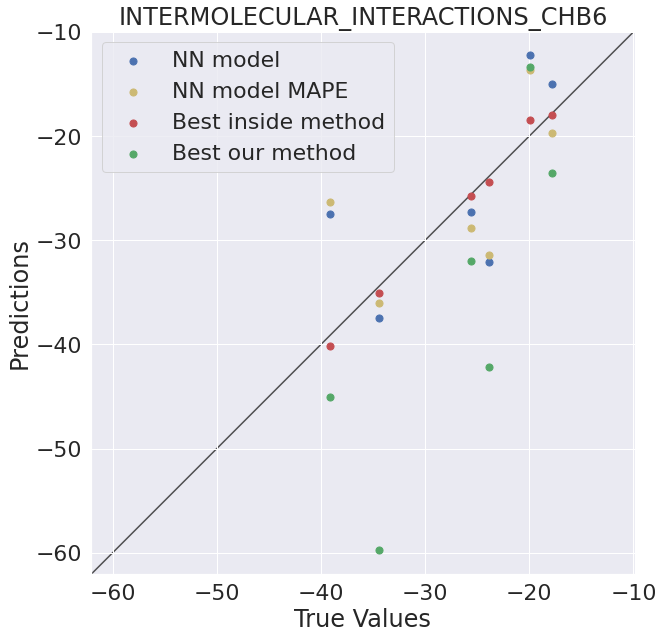

RMSE  INTERMOLECULAR_INTERACTIONS_HAL59  :  11.01
MAPE  INTERMOLECULAR_INTERACTIONS_HAL59  :   1.72
R2    INTERMOLECULAR_INTERACTIONS_HAL59  :  -5.82
RMSE MAPE INTERMOLECULAR_INTERACTIONS_HAL59  :   5.95
MAPE MAPE INTERMOLECULAR_INTERACTIONS_HAL59  :   1.10
R2   MAPE INTERMOLECULAR_INTERACTIONS_HAL59  :  -0.99


<Figure size 720x720 with 0 Axes>

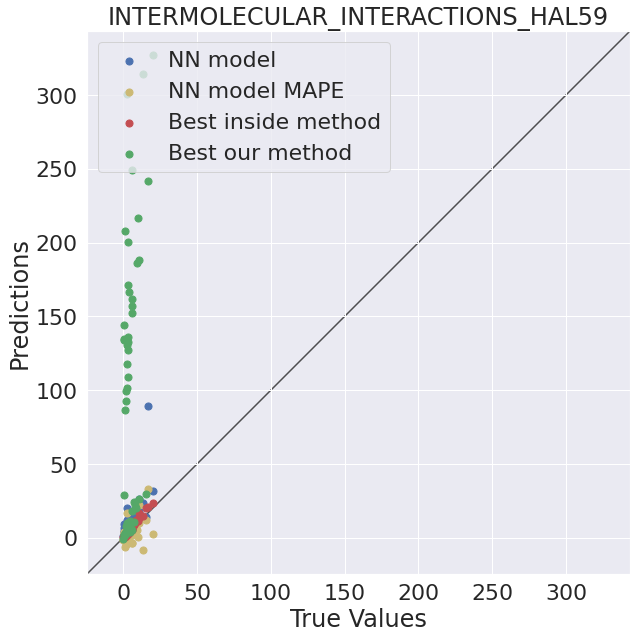

RMSE  INTERMOLECULAR_INTERACTIONS_IL16  :   4.16
MAPE  INTERMOLECULAR_INTERACTIONS_IL16  :   0.03
R2    INTERMOLECULAR_INTERACTIONS_IL16  :   0.73
RMSE MAPE INTERMOLECULAR_INTERACTIONS_IL16  :   4.66
MAPE MAPE INTERMOLECULAR_INTERACTIONS_IL16  :   0.03
R2   MAPE INTERMOLECULAR_INTERACTIONS_IL16  :   0.67


<Figure size 720x720 with 0 Axes>

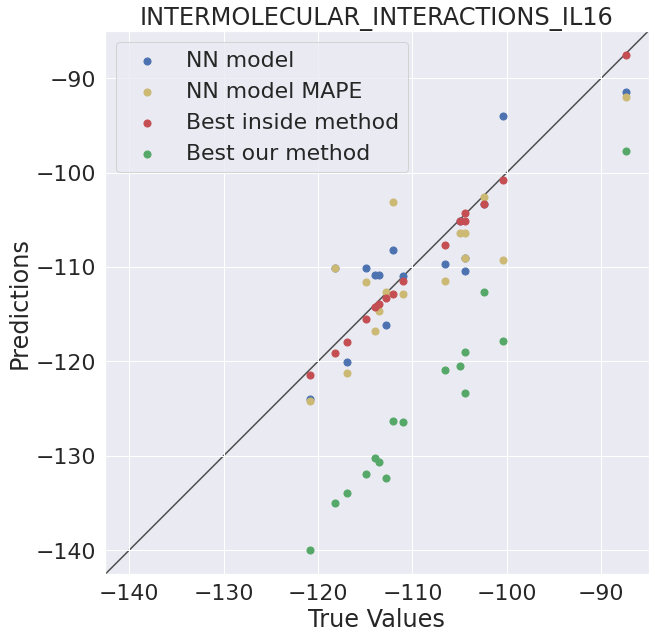

RMSE  INTERMOLECULAR_INTERACTIONS_PNICO23  :   2.69
MAPE  INTERMOLECULAR_INTERACTIONS_PNICO23  :   0.57
R2    INTERMOLECULAR_INTERACTIONS_PNICO23  :  -0.04
RMSE MAPE INTERMOLECULAR_INTERACTIONS_PNICO23  :   2.15
MAPE MAPE INTERMOLECULAR_INTERACTIONS_PNICO23  :   0.35
R2   MAPE INTERMOLECULAR_INTERACTIONS_PNICO23  :   0.33


<Figure size 720x720 with 0 Axes>

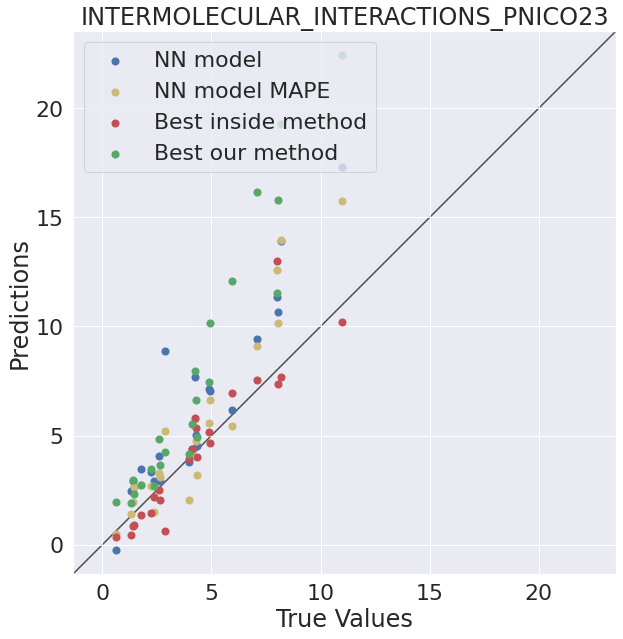

RMSE  INTERMOLECULAR_INTERACTIONS_RG18  :   1.86
MAPE  INTERMOLECULAR_INTERACTIONS_RG18  :   4.01
R2    INTERMOLECULAR_INTERACTIONS_RG18  : -20.54
RMSE MAPE INTERMOLECULAR_INTERACTIONS_RG18  :   1.10
MAPE MAPE INTERMOLECULAR_INTERACTIONS_RG18  :   2.98
R2   MAPE INTERMOLECULAR_INTERACTIONS_RG18  :  -6.45


<Figure size 720x720 with 0 Axes>

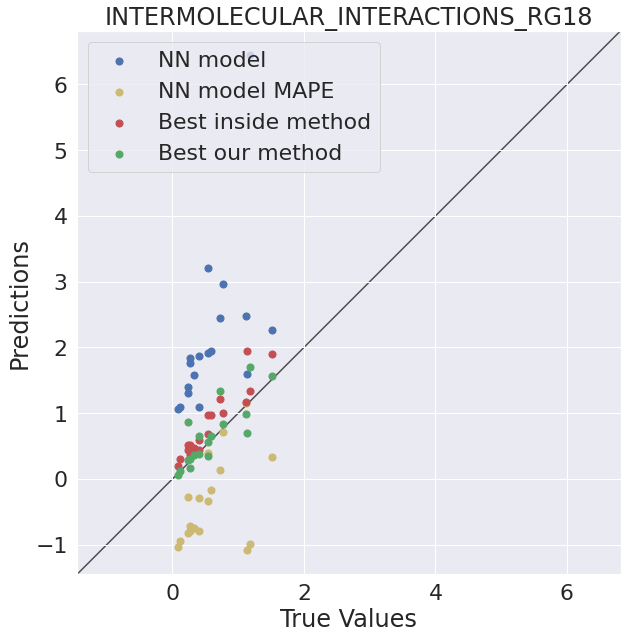

RMSE  INTERMOLECULAR_INTERACTIONS_S22  :   1.34
MAPE  INTERMOLECULAR_INTERACTIONS_S22  :   0.41
R2    INTERMOLECULAR_INTERACTIONS_S22  :   0.95
RMSE MAPE INTERMOLECULAR_INTERACTIONS_S22  :   1.24
MAPE MAPE INTERMOLECULAR_INTERACTIONS_S22  :   0.27
R2   MAPE INTERMOLECULAR_INTERACTIONS_S22  :   0.96


<Figure size 720x720 with 0 Axes>

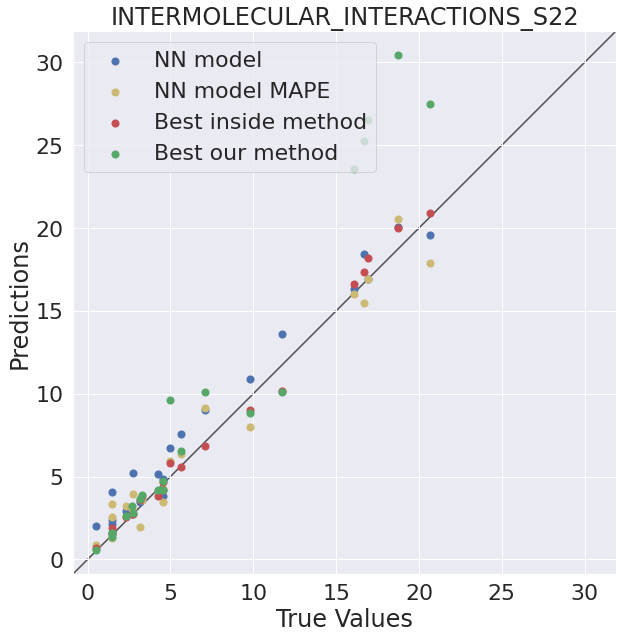

RMSE  INTERMOLECULAR_INTERACTIONS_S66  :   1.31
MAPE  INTERMOLECULAR_INTERACTIONS_S66  :   0.28
R2    INTERMOLECULAR_INTERACTIONS_S66  :   0.90
RMSE MAPE INTERMOLECULAR_INTERACTIONS_S66  :   0.85
MAPE MAPE INTERMOLECULAR_INTERACTIONS_S66  :   0.19
R2   MAPE INTERMOLECULAR_INTERACTIONS_S66  :   0.96


<Figure size 720x720 with 0 Axes>

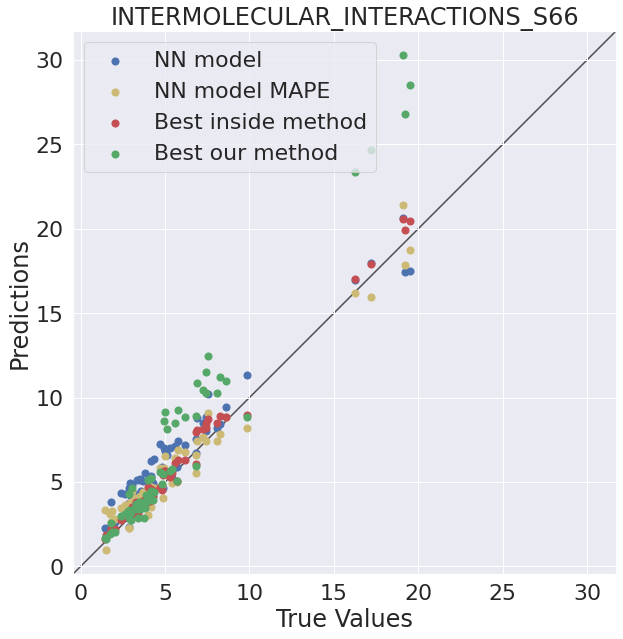

RMSE  INTERMOLECULAR_INTERACTIONS_WATER27  :   9.24
MAPE  INTERMOLECULAR_INTERACTIONS_WATER27  :   0.13
R2    INTERMOLECULAR_INTERACTIONS_WATER27  :   0.98
RMSE MAPE INTERMOLECULAR_INTERACTIONS_WATER27  :  11.66
MAPE MAPE INTERMOLECULAR_INTERACTIONS_WATER27  :   0.15
R2   MAPE INTERMOLECULAR_INTERACTIONS_WATER27  :   0.96


<Figure size 720x720 with 0 Axes>

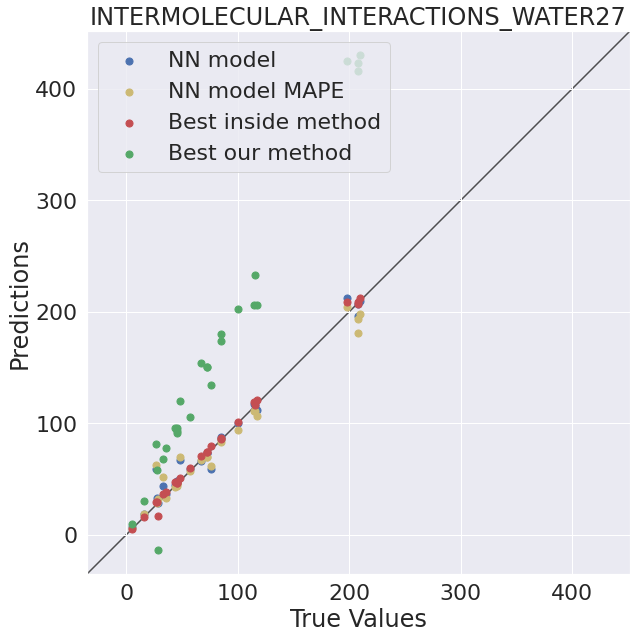

RMSE  LARGE_SYSTEMS  :  35.62
MAPE  LARGE_SYSTEMS  :   0.91
R2    LARGE_SYSTEMS  :   0.97
RMSE MAPE LARGE_SYSTEMS  :  37.27
MAPE MAPE LARGE_SYSTEMS  :   0.79
R2   MAPE LARGE_SYSTEMS  :   0.97


<Figure size 720x720 with 0 Axes>

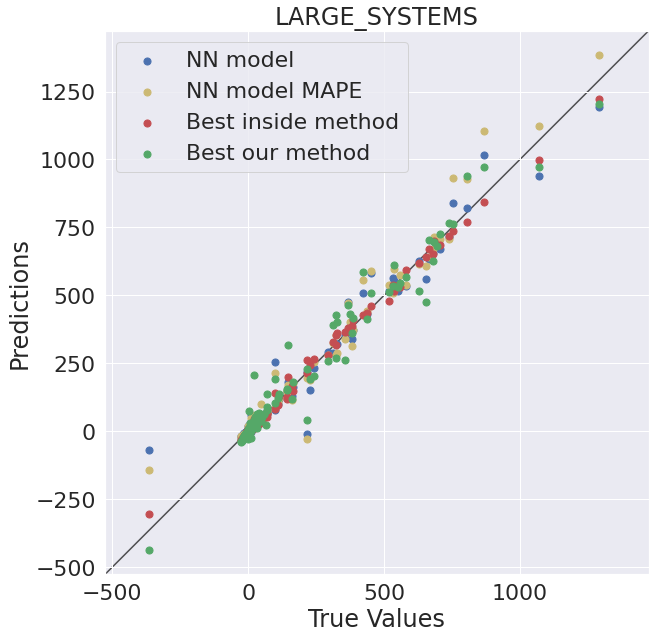

RMSE  LARGE_SYSTEMS_BSR36  :   2.06
MAPE  LARGE_SYSTEMS_BSR36  :   0.13
R2    LARGE_SYSTEMS_BSR36  :   0.96
RMSE MAPE LARGE_SYSTEMS_BSR36  :   2.65
MAPE MAPE LARGE_SYSTEMS_BSR36  :   0.11
R2   MAPE LARGE_SYSTEMS_BSR36  :   0.94


<Figure size 720x720 with 0 Axes>

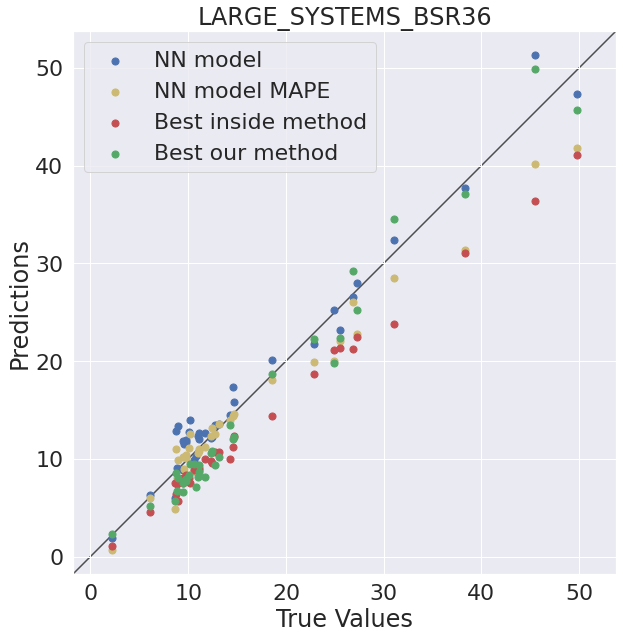

RMSE  LARGE_SYSTEMS_C60ISO  :   8.70
MAPE  LARGE_SYSTEMS_C60ISO  :   0.05
R2    LARGE_SYSTEMS_C60ISO  :   0.96
RMSE MAPE LARGE_SYSTEMS_C60ISO  :   7.57
MAPE MAPE LARGE_SYSTEMS_C60ISO  :   0.04
R2   MAPE LARGE_SYSTEMS_C60ISO  :   0.97


<Figure size 720x720 with 0 Axes>

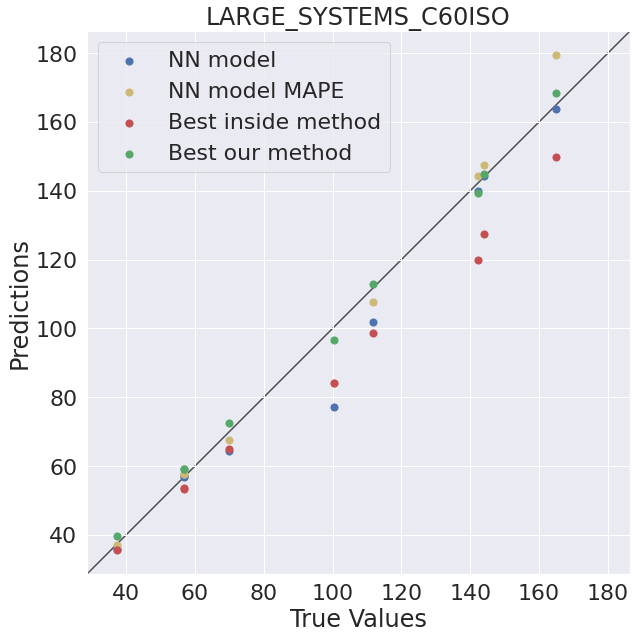

RMSE  LARGE_SYSTEMS_CDIE20  :   2.31
MAPE  LARGE_SYSTEMS_CDIE20  :   0.60
R2    LARGE_SYSTEMS_CDIE20  :   0.60
RMSE MAPE LARGE_SYSTEMS_CDIE20  :   1.04
MAPE MAPE LARGE_SYSTEMS_CDIE20  :   0.23
R2   MAPE LARGE_SYSTEMS_CDIE20  :   0.92


<Figure size 720x720 with 0 Axes>

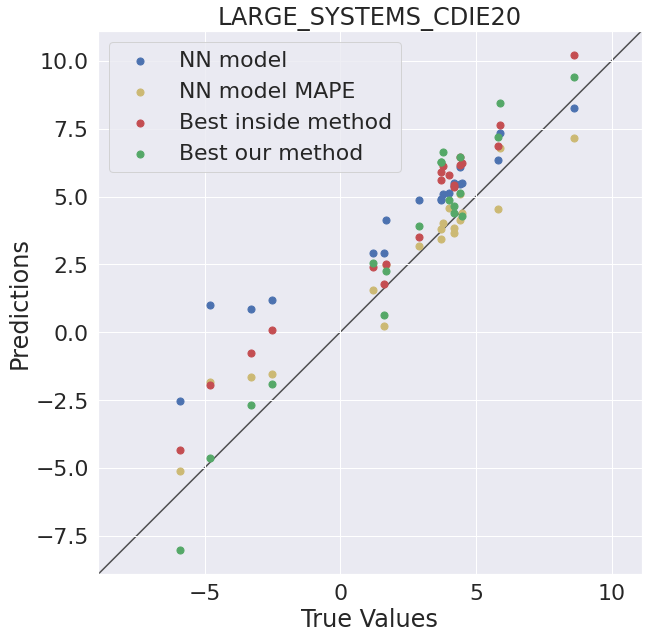

RMSE  LARGE_SYSTEMS_ISO34  :   5.73
MAPE  LARGE_SYSTEMS_ISO34  :   0.50
R2    LARGE_SYSTEMS_ISO34  :   0.84
RMSE MAPE LARGE_SYSTEMS_ISO34  :   6.32
MAPE MAPE LARGE_SYSTEMS_ISO34  :   0.72
R2   MAPE LARGE_SYSTEMS_ISO34  :   0.80


<Figure size 720x720 with 0 Axes>

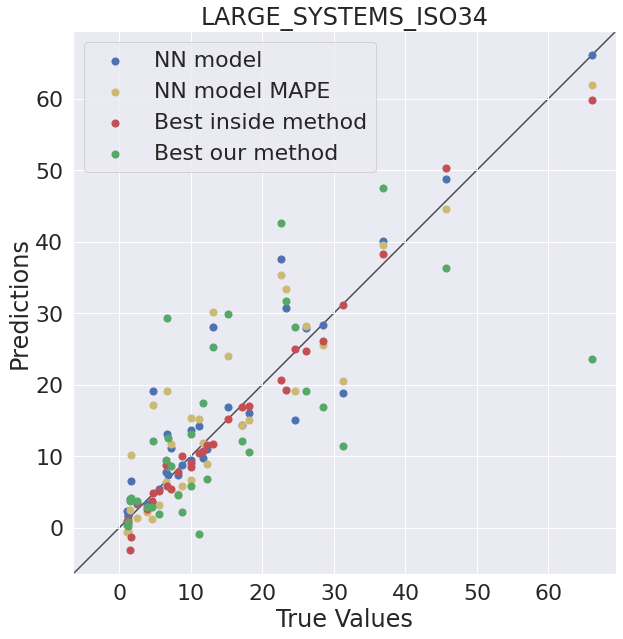

RMSE  LARGE_SYSTEMS_ISOL24  :  13.13
MAPE  LARGE_SYSTEMS_ISOL24  :   2.82
R2    LARGE_SYSTEMS_ISOL24  :   0.48
RMSE MAPE LARGE_SYSTEMS_ISOL24  :  12.06
MAPE MAPE LARGE_SYSTEMS_ISOL24  :   2.50
R2   MAPE LARGE_SYSTEMS_ISOL24  :   0.56


<Figure size 720x720 with 0 Axes>

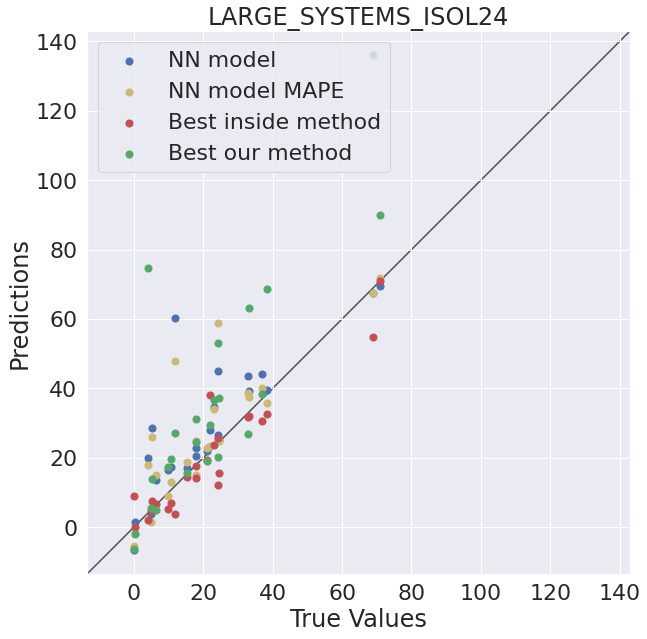

RMSE  LARGE_SYSTEMS_MB16-43  :  81.03
MAPE  LARGE_SYSTEMS_MB16-43  :   0.17
R2    LARGE_SYSTEMS_MB16-43  :   0.92
RMSE MAPE LARGE_SYSTEMS_MB16-43  :  85.07
MAPE MAPE LARGE_SYSTEMS_MB16-43  :   0.19
R2   MAPE LARGE_SYSTEMS_MB16-43  :   0.92


<Figure size 720x720 with 0 Axes>

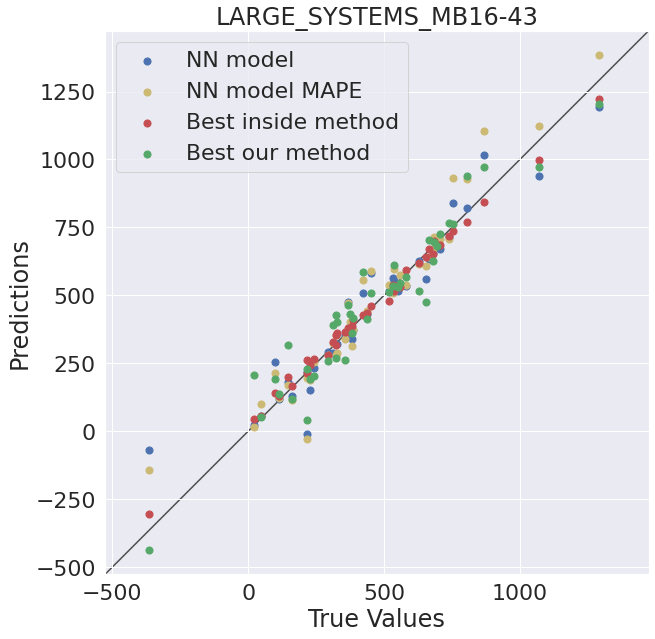

RMSE  LARGE_SYSTEMS_PArel  :   8.14
MAPE  LARGE_SYSTEMS_PArel  :   2.94
R2    LARGE_SYSTEMS_PArel  :  -2.80
RMSE MAPE LARGE_SYSTEMS_PArel  :   7.28
MAPE MAPE LARGE_SYSTEMS_PArel  :   2.73
R2   MAPE LARGE_SYSTEMS_PArel  :  -2.04


<Figure size 720x720 with 0 Axes>

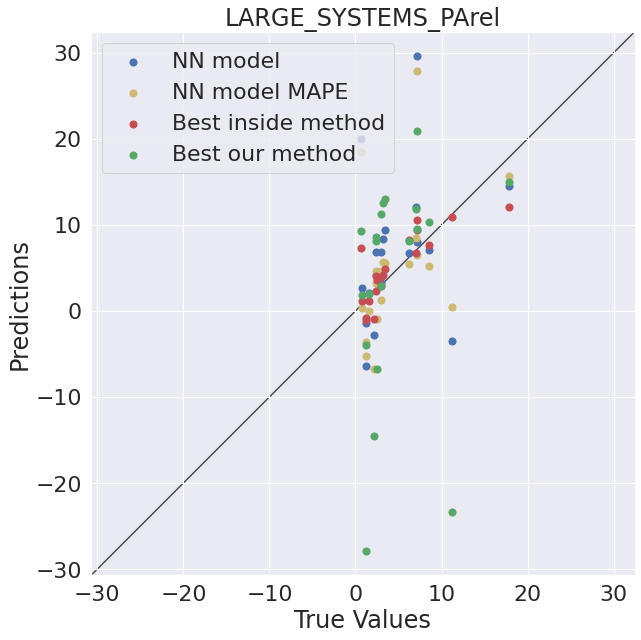

RMSE  LARGE_SYSTEMS_RSE43  :   3.75
MAPE  LARGE_SYSTEMS_RSE43  :   0.97
R2    LARGE_SYSTEMS_RSE43  :   0.74
RMSE MAPE LARGE_SYSTEMS_RSE43  :   2.38
MAPE MAPE LARGE_SYSTEMS_RSE43  :   0.59
R2   MAPE LARGE_SYSTEMS_RSE43  :   0.89


<Figure size 720x720 with 0 Axes>

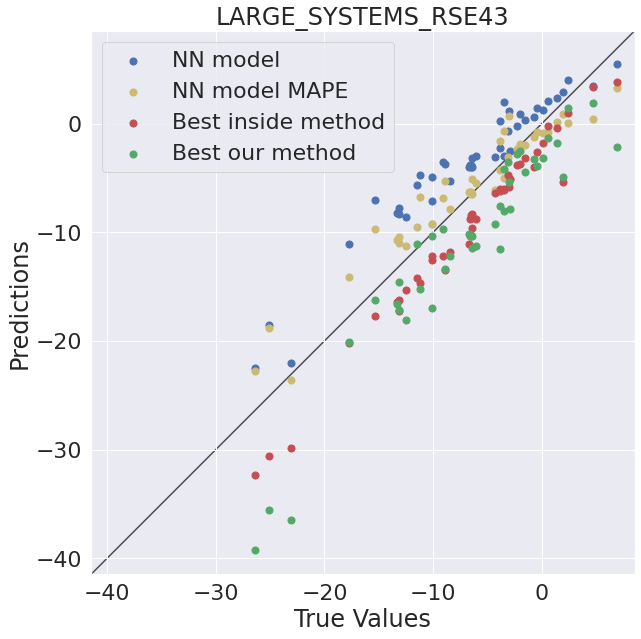

RMSE  Full  :  20.23
MAPE  Full  :   1.09
R2    Full  :   0.99
RMSE MAPE Full  :  20.14
MAPE MAPE Full  :   0.95
R2   MAPE Full  :   0.99


<Figure size 720x720 with 0 Axes>

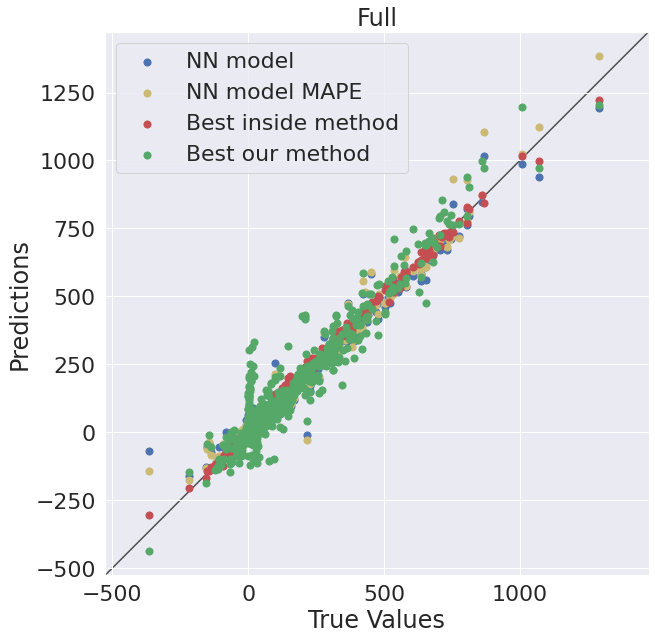

In [17]:
for setname in fullsetnames:
    X, Y, features_names = \
            commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                    models_results[setname].labels)
    y_pred = models_results[setname].y_pred 
    rmse = mean_squared_error(Y, y_pred, squared=False)
    mape = mean_absolute_percentage_error(Y, y_pred)
    r2 = r2_score(Y, y_pred)
    print("RMSE ", setname, " : %6.2f"%rmse)
    print("MAPE ", setname, " : %6.2f"%mape)
    print("R2   ", setname, " : %6.2f"%r2)
    
    y_pred_mape = models_results[setname].y_pred_mape
    rmse = mean_squared_error(Y, y_pred_mape, squared=False)
    mape = mean_absolute_percentage_error(Y, y_pred_mape)
    r2 = r2_score(Y, y_pred_mape)
    print("RMSE MAPE", setname, " : %6.2f"%rmse)
    print("MAPE MAPE", setname, " : %6.2f"%mape)
    print("R2   MAPE", setname, " : %6.2f"%r2)
    plt.clf()
    #plt.scatter(Y, y_pred)

    fig, ax = plt.subplots()
    ax.scatter(Y, y_pred, c='b', s=50, label='NN model')
    ax.scatter(Y, y_pred_mape, c='y', s=50, label='NN model MAPE')
    ax.scatter(Y, models_results[setname].y_pred_bestinsidemethod, \
                c='r', s=50, label='Best inside method')
    ax.scatter(Y, models_results[setname].y_pred_bestourmethod, \
               c='g', s=50, label='Best our method')
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.legend(loc="upper left")
    plt.title(setname)
    plt.show()